# **Stage 4: Combined Augmentation Models for Hubert Speech Emotion Recognition**


#### **Overview**
This notebook implements Stage 4 of our HuBERT-SER emotion recognition project, where we combine multiple augmentation techniques based on their individual performance in Stage 3.

#### **Approach**
We develop three combined models:
1. **Two-method combination**: Integrates the two best-performing techniques (SpecAugment + Time Stretch)
2. **Three-method combination**: Adds the third best technique (+ Noise)
3. **Comprehensive model**: Incorporates all augmentation methods with probability weights

Each training sample is augmented using a probability-weighted selection mechanism that favors techniques that demonstrated better performance in our individual evaluations.

#### **Workflow**
1. General Preparation
2. Weight Calculation for Combined Augmentation Models
3. Combined Augmentation Dataset Generation
4. Preprocess and Training
5. Results Evaluation and Comparison
6. Performance Summary of All Models

#### **Key notes**
- Augmentation probability weights based on Stage 3 performance
- 1:1 ratio of clean to augmented data maintained
- Identical training hyperparameters across all models

## 1. General Preparation

In [ ]:
# Install required packages
%%capture
!pip install datasets transformers evaluate accelerate torch
!pip install torch torchaudio

Import some common libraries.

In [ ]:
import time
from tqdm import tqdm
import torch
import os
import soundfile as sf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification
from datasets import Dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
import librosa
from sklearn.metrics import classification_report, confusion_matrix
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio


Use GPU Facilities

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Set Seed for Reproducibility

In [ ]:
SEED = 42

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(SEED)

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Paths - **Project Base_DIR is Needed**

In [ ]:
BASE_DIR = "/content/drive/MyDrive/YourProject"

## 2. Weight Calculation for Combined Augmentation Models

In this section, we calculate weights for each augmentation technique based on their performance gains over the baseline model. We use the F1 weighted scores from the combined test sets (which contain both clean and augmented samples) as our performance metric.

The weights are determined by:
1. Measuring the gain (f1-weighted) that each method provides over baseline
2. Normalizing these gains to create a probability distribution

This mathematical approach ensures our weighting scheme directly reflects each method's empirical contribution to model improvement.

In [ ]:
# F1 weighted scores from individual augmentation models on combined dataset F1 score
model_performance = {
    'Baseline' : 0.586,
    'TimeStretch': 0.718,
    'SpecAugment': 0.756,
    'CopyPaste': 0.684,
    'Noise': 0.654
}

# Calculate augmentation weights based on performance gains over baseline
def calculate_augmentation_weights(performance_dict):
    """
    Calculate augmentation weights based on performance gains over baseline.
    performance_dict: Dictionary with method names and F1 scores
    """
    # Calculate gain over baseline
    baseline = performance_dict['Baseline']
    methods_dict = {k: v for k, v in performance_dict.items() if k != 'Baseline'}

    gains = {method: score - baseline for method, score in methods_dict.items()}

    # Create DataFrame for visualization
    gains_df = pd.DataFrame({
        'Method': list(gains.keys()),
        'F1 Score': list(methods_dict.values()),
        'Gain': list(gains.values())
    })

    print("Performance gains over baseline:")
    display(gains_df.sort_values('Gain', ascending=False))

    # Calculate normalized weights
    total_gain = sum(gains.values())
    weights = {method: gain/total_gain for method, gain in gains.items()}

    return weights

In [ ]:
augmentation_weights

{'TimeStretch': 0.28205128205128194,
 'SpecAugment': 0.3632478632478632,
 'CopyPaste': 0.2094017094017095,
 'Noise': 0.14529914529914537}

**An elegant report visualization**

Performance gains over baseline:


,Method,F1 Score,Gain
1,SpecAugment,0.756,0.170
0,TimeStretch,0.718,0.132
2,CopyPaste,0.684,0.098
3,Noise,0.654,0.068


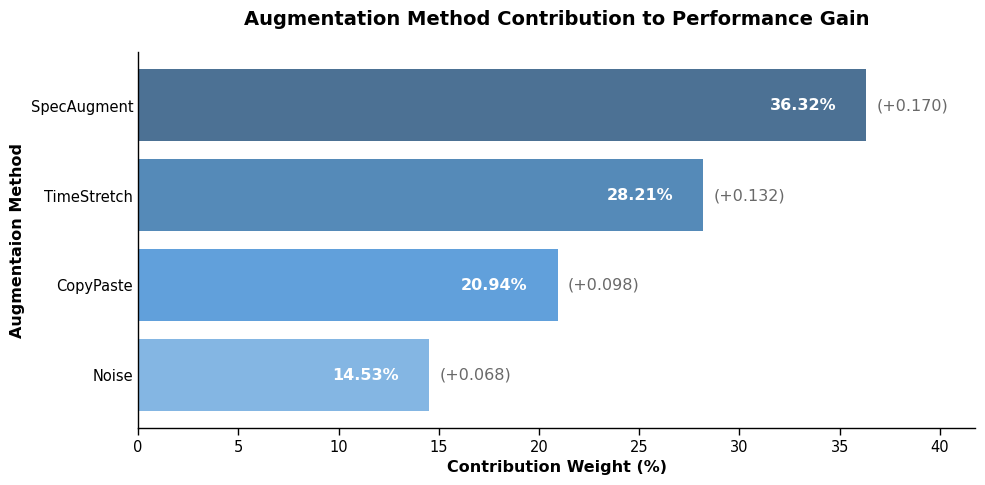

In [ ]:
# Calculate augmentation weights
augmentation_weights = calculate_augmentation_weights(model_performance)

# Set publication-ready style
plt.style.use('default')
sns.set_context("paper", font_scale=1.2)

# Create horizontal bar chart (more professional than pie chart)
fig, ax = plt.subplots(figsize=(10, 5))

# Convert weights dictionary to sorted lists for plotting
methods = sorted(augmentation_weights.keys(), key=lambda x: augmentation_weights[x])
weights_pct = [augmentation_weights[m] * 100 for m in methods]
gains = [model_performance[m] - model_performance['Baseline'] for m in methods]

# Color palette
colors = ["#66a4dc","#3988d2","#2b6da6","#1f4e79"]

# Plot horizontal bars for weights
bars = ax.barh(methods, weights_pct, color=colors, alpha=0.8, edgecolor='none')

# Add weight percentage labels inside the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width - 1.5, bar.get_y() + bar.get_height()/2,
            f"{weights_pct[i]:.2f}%",
            ha='right', va='center', fontweight='bold', color='white')

# Add absolute gain labels to the right of bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"(+{gains[i]:.3f})",
            ha='left', va='center', color='dimgray')

# Customize axes
ax.set_xlabel('Contribution Weight (%)', fontweight='bold')
ax.set_ylabel('Augmentaion Method', fontweight='bold')
ax.set_xlim(0, max(weights_pct) * 1.15)  # Add some padding
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', length=0)

# Add title and subtitle
plt.title('Augmentation Method Contribution to Performance Gain',
          fontsize=14, fontweight='bold', pad=20)

# Save figure in high resolution
plt.tight_layout()
plt.savefig('augmentation_weights.png', dpi=300, bbox_inches='tight')

plt.show()

## 3. Combined Augmentation Dataset Generation

**Augmentation methods**

In [ ]:
def ncp_augmentation(emotional_audio: np.ndarray,
                         neutral_audio: np.ndarray) -> np.ndarray:
    """
    Apply Neutral-CopyPaste augmentation to create an emotionally augmented utterance.

    Args:
        emotional_audio: Source array containing emotional speech
        neutral_audio: Target array containing neutral speech to be augmented

    Returns:
        Augmented audio array with emotional segment inserted
    """
    # Calculate the length of each part (divide neutral into three equal parts)
    part_length = len(neutral_audio) // 3

    # Extract the three parts of neutral audio
    neutral_part1 = neutral_audio[0:part_length]
    neutral_part3 = neutral_audio[2*part_length:3*part_length]

    # Extract matching length segment from emotional audio
    emotional_start = (len(emotional_audio) - part_length) // 2
    emotional_segment = emotional_audio[emotional_start:emotional_start + part_length]

    # Create the result by concatenating parts
    result = np.concatenate([
        neutral_part1,      # First part: neutral
        emotional_segment,  # Middle part: emotional
        neutral_part3       # Last part: neutral
    ])

    return result

def time_stretch(audio, rate=1.0):
    return librosa.effects.time_stretch(y=audio, rate=rate)

def add_noise(audio, noise_level=0.005):
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

def spec_augment(audio, sample_rate, time_mask_param=30, freq_mask_param=10):
    np.random.seed(SEED)  # Ensure reproducibility
    time_mask = np.random.uniform(0, time_mask_param)
    freq_mask = np.random.uniform(0, freq_mask_param)
    augmented_audio = audio.copy()
    # Apply time mask
    if len(audio) > time_mask:
        start = np.random.randint(0, len(audio) - int(time_mask))
        augmented_audio[start: start + int(time_mask)] = 0
    # Apply frequency mask (simulated as scaling random parts of audio)
    if freq_mask < len(audio):
        start = np.random.randint(0, len(audio) - int(freq_mask))
        augmented_audio[start: start + int(freq_mask)] *= 0.5
    return augmented_audio

# Fixed Parameters for Each Augmentation
param_values = {
    "time_stretch": [0.8, 0.9, 1.0, 1.1, 1.2],
    "add_noise": [0.001, 0.005, 0.01],
    "copy_paste": [0.5, 0.6, 0.7],
    "spec_augment": {
        "time_mask_param": [10, 20, 30],
        "freq_mask_param": [10, 20, 30]
    }
}

**Method selection and weight calculation**

In [ ]:
def filter_top_methods(performance_dict, n_top_methods):
    """Filter to keep only top n methods by performance"""
    # Remove baseline
    methods_dict = {k: v for k, v in performance_dict.items() if k != 'Baseline'}

    # Sort by performance
    sorted_methods = sorted(methods_dict.items(), key=lambda x: x[1], reverse=True)

    # Select top n
    top_methods = dict(sorted_methods[:n_top_methods])

    # Add baseline back
    filtered_dict = {'Baseline': performance_dict['Baseline']}
    filtered_dict.update(top_methods)

    return filtered_dict

**Augmentation application**

Creating a data frame with combination of methods

In [ ]:
def create_combined_augmentation_dataset(df, model_performance, n_methods, split):
    """Generate dataset with top n augmentation methods based on weights"""
    # Filter top methods
    filtered_perf = filter_top_methods(model_performance, n_methods)
    method_weights = calculate_augmentation_weights(filtered_perf)

    # Prepare methods and probabilities
    methods = list(method_weights.keys())
    probs = list(method_weights.values())

    # Create output directory
    save_dir = f"augmented/{split}/combined_{n_methods}"
    os.makedirs(save_dir, exist_ok=True)

    # Handle NCP special case
    neutral_samples = df[df['emotion'] == 'neutral']
    emotional_samples = df[df['emotion'] != 'neutral']

    augmented_rows = []
    # For each sample we create an augmented version
    for idx, row in df.iterrows():
        # Sample augmentation method
        method = np.random.choice(methods, p=probs)

        # Load audio
        audio, sr = librosa.load(row['path'], sr=16000)

        # Apply method-specific augmentation
        if method == 'TimeStretch':
            rate = np.random.choice(param_values["time_stretch"])
            aug_audio = time_stretch(audio, rate=rate)
            param_str = f"rate{rate}"
        elif method == 'SpecAugment':
            time_mask = np.random.choice(param_values["spec_augment"]["time_mask_param"])
            freq_mask = np.random.choice(param_values["spec_augment"]["freq_mask_param"])
            aug_audio = spec_augment(audio, sr, time_mask_param=time_mask, freq_mask_param=freq_mask)
            param_str = f"time{time_mask}_freq{freq_mask}"
        elif method == 'Noise':
            noise_level = np.random.choice(param_values["add_noise"])
            aug_audio = add_noise(audio, noise_level=noise_level)
            param_str = f"noise{noise_level}"
        elif method == 'CopyPaste':
            # For NCP, get random neutral or emotional sample
            if row['emotion'] != 'neutral': #emtional
              neutral_row = neutral_samples.sample(1).iloc[0]
              other_audio, _ = librosa.load(neutral_row['path'], sr=16000)
              param_str = f"neutral{neutral_row.name}"
            else: #netural
              emotional_row = emotional_samples.sample(1).iloc[0]
              other_audio, _ = librosa.load(emotional_row['path'], sr=16000)
              param_str = f"emotional{emotional_row.name}"
            aug_audio = ncp_augmentation(audio, other_audio)
        else:
            # Fallback to noise if we can't apply the chosen method
            noise_level = np.random.choice(param_values["add_noise"])
            aug_audio = add_noise(audio, noise_level=noise_level)
            param_str = f"fallback_noise{noise_level}"

        # Save augmented audio
        aug_path = os.path.join(save_dir, f"{idx}_{method}_{param_str}.wav")
        sf.write(aug_path, aug_audio, sr)

        # Create new row
        new_row = row.copy()
        new_row['path'] = aug_path
        new_row['aug_type'] = method
        augmented_rows.append(new_row)

    return pd.DataFrame(augmented_rows)

**Ravdness clean datasets loading**

In [ ]:
def load_dataset(dataset_name, set_type, base_dir=f"{BASE_DIR}/Datasets"):
    """Load dataset from the organized structure"""
    metadata_path = os.path.join(base_dir, dataset_name, set_type, 'metadata.pkl')

    if os.path.exists(metadata_path):
        return pd.read_pickle(metadata_path)
    else:
        raise FileNotFoundError(f"Dataset not found at {metadata_path}")

In [ ]:
drive_path = f"{BASE_DIR}/Datasets"
clean_train_df = load_dataset('clean', 'train', drive_path)
clean_test_df = load_dataset('clean', 'test', drive_path)

In [ ]:
clean_train_df

,gender,emotion,labels,source,path,aug_type,aug_params
312,female,happy,3,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
993,male,happy,3,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
945,female,angry,5,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
277,male,surprise,8,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
134,male,surprise,8,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
...,...,...,...,...,...,...,...
373,male,surprise,8,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
1072,female,sad,4,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
1177,female,sad,4,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None
1069,female,surprise,8,RAVDESS,/content/drive/Shared drives/מבוא ללמידה עמוקה...,clean,None


A look at an audio sample


In [ ]:
# Display the first data.
import IPython.display as ipd
id = 0
print(clean_train_df.iloc[id])
ipd.Audio(data=clean_train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                   female
emotion                                                   happy
labels                                                        3
source                                                  RAVDESS
path          /content/drive/Shared drives/מבוא ללמידה עמוקה...
aug_type                                                  clean
aug_params                                                 None
Name: 312, dtype: object


**Generate datasets for specified method counts**

In [ ]:
combined_datasets = {}
for n in [2, 3, 4]:
    train_combined = create_combined_augmentation_dataset(clean_train_df, model_performance, n, 'train')
    test_combined = create_combined_augmentation_dataset(clean_test_df, model_performance, n, 'test')

    combined_datasets[f'top_{n}'] = {
        'train': train_combined,
        'test': test_combined
    }

Performance gains over baseline:


,Method,F1 Score,Gain
0,SpecAugment,0.756,0.170
1,TimeStretch,0.718,0.132


Performance gains over baseline:


,Method,F1 Score,Gain
0,SpecAugment,0.756,0.170
1,TimeStretch,0.718,0.132


Performance gains over baseline:


,Method,F1 Score,Gain
0,SpecAugment,0.756,0.170
1,TimeStretch,0.718,0.132
2,CopyPaste,0.684,0.098


Performance gains over baseline:


,Method,F1 Score,Gain
0,SpecAugment,0.756,0.170
1,TimeStretch,0.718,0.132
2,CopyPaste,0.684,0.098


Performance gains over baseline:


,Method,F1 Score,Gain
0,SpecAugment,0.756,0.170
1,TimeStretch,0.718,0.132
2,CopyPaste,0.684,0.098
3,Noise,0.654,0.068


Performance gains over baseline:


,Method,F1 Score,Gain
0,SpecAugment,0.756,0.170
1,TimeStretch,0.718,0.132
2,CopyPaste,0.684,0.098
3,Noise,0.654,0.068


**Saving each combined augmented dataset**

In [ ]:
import os
import shutil
import pandas as pd
import pickle

def save_dataset(df, set_type, dataset_name, base_dir='datasets'):
    """
    Save dataset with audio files in an organized structure

    Args:
        df: DataFrame with 'path' column pointing to audio files
        set_type: Type of dataset (e.g., 'train', 'test', 'validation')
        dataset_name: Name of the dataset (e.g., 'original', 'augmented', 'noisy')
        base_dir: Base directory for all datasets
    """
    # Create directory structure
    save_dir = os.path.join(base_dir, dataset_name, set_type)
    audio_dir = os.path.join(save_dir, 'audio')
    os.makedirs(audio_dir, exist_ok=True)

    # Copy with updated paths
    new_df = df.copy()

    for idx, row in df.iterrows():
        audio_file = os.path.basename(row['path'])
        new_path = os.path.join(audio_dir, audio_file)
        shutil.copy2(row['path'], new_path)
        new_df.at[idx, 'path'] = new_path

    # Save metadata
    new_df.to_pickle(os.path.join(save_dir, 'metadata.pkl'))
    new_df.to_csv(os.path.join(save_dir, 'metadata.csv'), index=False)

shared_drive_path = f"{BASE_DIR}/Datasets"

# Saving all the new sets
for dataset_key, dataset_dict in combined_datasets.items():
    # Save train data
    save_dataset(dataset_dict['train'], 'train', dataset_key, base_dir=shared_drive_path)

    # Save test data
    save_dataset(dataset_dict['test'], 'test', dataset_key, base_dir=shared_drive_path)

    # Create combined versions
    train_combined = pd.concat([clean_train_df, dataset_dict['train']], ignore_index=True)
    test_combined = pd.concat([clean_test_df, dataset_dict['test']], ignore_index=True)

    # Save combined versions
    save_dataset(train_combined, 'train_combined', dataset_key, base_dir=shared_drive_path)
    save_dataset(test_combined, 'test_combined', dataset_key, base_dir=shared_drive_path)

## 4. Pre-process and Training
*   Loading pre-trained HuBERT-SER model and Datasets objects.
*   Training three combined models on the combined train datasets.

In [ ]:
def map_to_array(example):
   speech, _ = librosa.load(example["path"], sr=16000, mono=True)
   example["speech"] = speech
   return example

class EmotionDataset(torch.utils.data.Dataset):
   def __init__(self, encodings, labels):
       self.encodings = encodings
       pattern = {
           1: 0,  # neutral
           2: 0,  # neutral
           3: 1,  # happy
           4: 2,  # sad
           5: 3,  # angry
           6: 4,  # fear
           7: 5,  # disgust
           8: 6   # surprise
       }
       self.labels = [pattern[x] for x in labels]

   def __getitem__(self, idx):
       item = {key: val[idx] for key, val in self.encodings.items()}
       item['labels'] = torch.tensor(self.labels[idx])
       return item

   def __len__(self):
       return len(self.labels)

# Prediction function
def predict(outputs):
   probabilities = torch.softmax(outputs["logits"], dim=1)
   predictions = torch.argmax(probabilities, dim=1)
   return predictions

**Train and save a model using a trainset**

In [ ]:
def train_hubert_model(train_df, model_name, save_path_base):
    """Train a single HuBERT model on a provided trainset"""
    # Prepare data
    train_data = Dataset.from_pandas(train_df).map(map_to_array)

    # Feature extraction
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")
    train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

    # Create datasets
    train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))

    # Loading the optimizer
    model = HubertForSequenceClassification.from_pretrained(
      "superb/hubert-large-superb-er",
      num_labels=7,
      ignore_mismatched_sizes=True
    )
    model.to(device)

    optim = AdamW(model.parameters(), lr=1e-5)

    # Training

    print(f"Training {model_name}...")
    epochs = 7
    batch_size = 8
    train_loss = []
    train_accuracies = []

    model.train()
    for epoch_i in range(epochs):
        print(f'Epoch {epoch_i + 1}/{epochs}')
        time.sleep(0.3)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        count = 0
        epoch_loss = []

        pbar = tqdm(train_loader)
        for batch in pbar:
            optim.zero_grad()
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            loss.backward()
            optim.step()

            predictions = predict(outputs)
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct / count

            pbar.set_postfix({
                'Loss': f'{loss.item():.3f}',
                'Accuracy': f'{accuracy:.3f}'
            })
            epoch_loss.append(loss.item())

        pbar.close()
        train_loss += epoch_loss
        train_accuracies.append(accuracy)


    # Plot Iteration vs Training Loss
    plt.plot(train_loss, label=f"Training Loss - {model_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Iteration vs Training Loss")
    plt.legend()
    plt.show()

    # Plot Epoch vs Training Accuracy
    acc_X = np.arange(len(train_accuracies))+1
    plt.plot(acc_X, train_accuracies,"-", label=f"Training Accuracy - {model_name}")
    plt.xticks(acc_X)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Training Accuracy")
    plt.legend()
    plt.show()

    # Saving model
    model_save_path = os.path.join(save_path_base, model_name)
    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path)
    feature_extractor.save_pretrained(model_save_path)

    print(f"Model {model_name} saved to {model_save_path}")

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training top_2...
Epoch 1/7



100%|██████████| 250/250 [01:22<00:00,  3.04it/s, Loss=1.756, Accuracy=0.266]


Epoch 2/7


100%|██████████| 250/250 [01:19<00:00,  3.14it/s, Loss=0.697, Accuracy=0.549]


Epoch 3/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=0.349, Accuracy=0.731]


Epoch 4/7


100%|██████████| 250/250 [01:20<00:00,  3.10it/s, Loss=0.556, Accuracy=0.792]


Epoch 5/7


100%|██████████| 250/250 [01:19<00:00,  3.14it/s, Loss=0.053, Accuracy=0.824]


Epoch 6/7


100%|██████████| 250/250 [01:19<00:00,  3.13it/s, Loss=0.169, Accuracy=0.854]


Epoch 7/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=1.297, Accuracy=0.893]


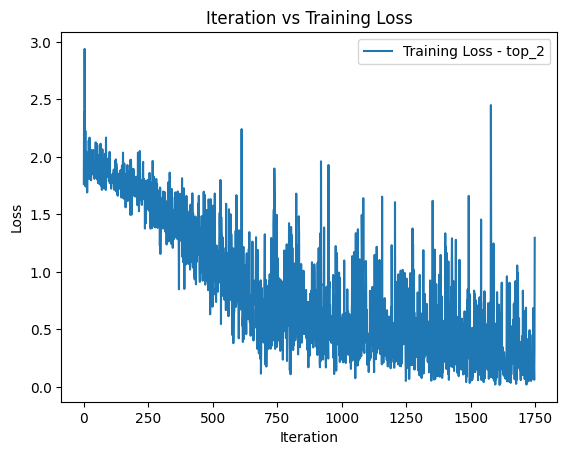

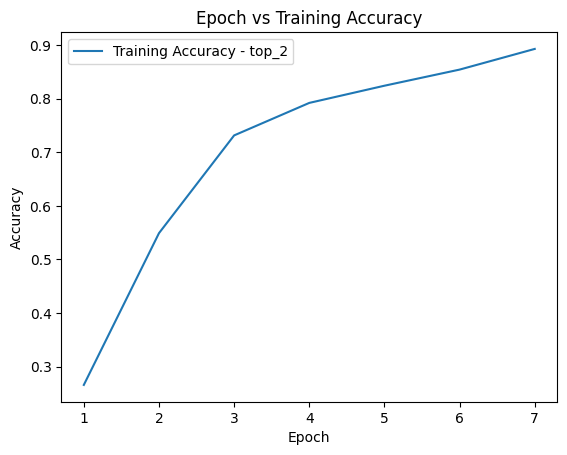

Model top_2 saved to /content/drive/Shared drives/מבוא ללמידה עמוקה - DL/פרויקט/Augmentation/Augmented models/New top/top_2/top_2


Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training top_3...
Epoch 1/7


100%|██████████| 250/250 [01:20<00:00,  3.11it/s, Loss=1.608, Accuracy=0.272]


Epoch 2/7


100%|██████████| 250/250 [01:19<00:00,  3.14it/s, Loss=2.070, Accuracy=0.537]


Epoch 3/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=0.926, Accuracy=0.695]


Epoch 4/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=0.349, Accuracy=0.762]


Epoch 5/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=0.048, Accuracy=0.811]


Epoch 6/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=0.341, Accuracy=0.847]


Epoch 7/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=0.220, Accuracy=0.871]


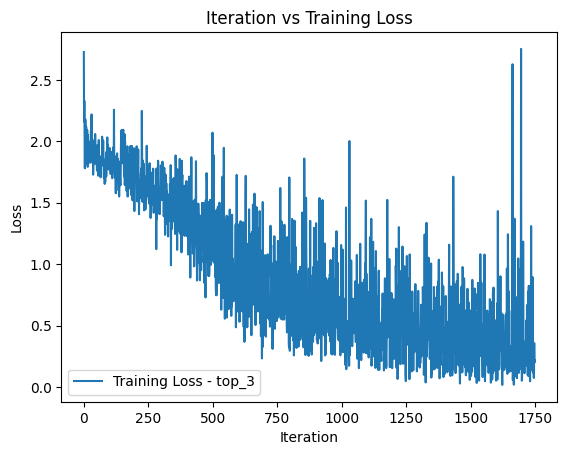

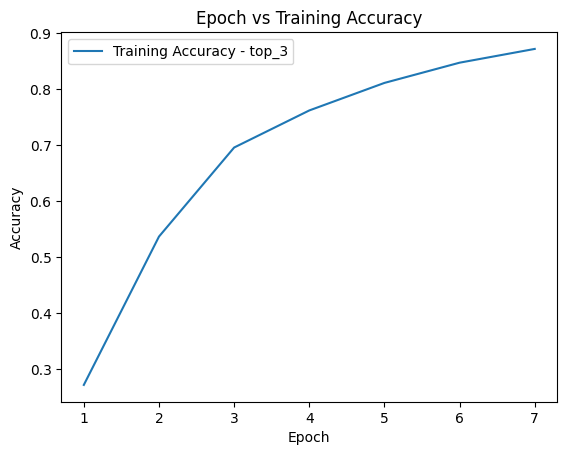

Model top_3 saved to /content/drive/Shared drives/מבוא ללמידה עמוקה - DL/פרויקט/Augmentation/Augmented models/New top/top_3/top_3


Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training top_4...
Epoch 1/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=1.453, Accuracy=0.327]


Epoch 2/7


100%|██████████| 250/250 [01:20<00:00,  3.11it/s, Loss=0.892, Accuracy=0.599]


Epoch 3/7


100%|██████████| 250/250 [01:19<00:00,  3.14it/s, Loss=0.136, Accuracy=0.728]


Epoch 4/7


100%|██████████| 250/250 [01:19<00:00,  3.14it/s, Loss=0.157, Accuracy=0.792]


Epoch 5/7


100%|██████████| 250/250 [01:20<00:00,  3.12it/s, Loss=0.520, Accuracy=0.830]


Epoch 6/7


100%|██████████| 250/250 [01:20<00:00,  3.10it/s, Loss=0.031, Accuracy=0.868]


Epoch 7/7


100%|██████████| 250/250 [01:20<00:00,  3.11it/s, Loss=0.075, Accuracy=0.893]


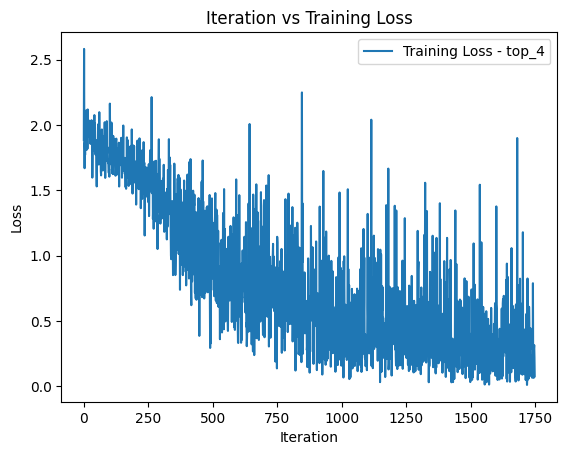

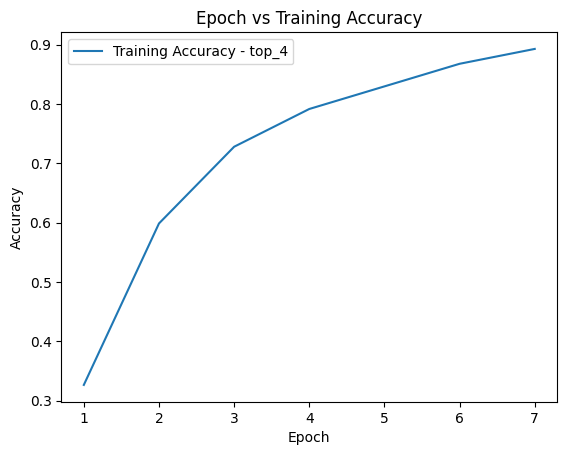

Model top_4 saved to /content/drive/Shared drives/מבוא ללמידה עמוקה - DL/פרויקט/Augmentation/Augmented models/New top/top_4/top_4


In [ ]:
datasets_path = f"{BASE_DIR}/Datasets"
save_path_base = f"{BASE_DIR}/Augmentation/Augmented models"
for dataset_key, dataset_dict in combined_datasets.items():
    # Create combined versions
    train_combined = load_dataset(dataset_key, 'train_combined', datasets_path)
    # Train a model
    model_save_path = f"{save_path_base}/{dataset_key}"
    train_hubert_model(train_combined, dataset_key, model_save_path)

## 5. Results Evaluation and Comparison

**Load the test sets**

In [ ]:
import os
import shutil
import pandas as pd
import pickle

def load_test_sets(base_dir='test_sets_backup'):
    """
    Loads all saved test sets and restores original naming with spaces.
    """
    loaded_sets = {}

    # Go through each folder in the base directory
    for set_folder in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, set_folder)):
            # Load the DataFrame
            df_path = os.path.join(base_dir, set_folder, 'metadata.pkl')
            if os.path.exists(df_path):
                # Convert folder name back to original format (replace underscores with spaces)
                original_name = set_folder.replace('_', ' ')
                loaded_sets[original_name] = pd.read_pickle(df_path)

    return loaded_sets

In [ ]:
# Load all test sets
test_sets_path = f"{BASE_DIR}/Datasets/RAVDNESS/all_tests"
loaded_test_sets = load_test_sets(test_sets_path)

**Function to test a single test set given a model**

In [ ]:
def evaluate_test_set(model, model_name, test_df, set_name, device, feature_extractor):
    """
    Evaluates model performance on a given test set and generates analysis

    Args:
        model: The trained model
        test_df: DataFrame containing test data
        set_name: String identifying the test set (e.g., 'Noise', 'Time Stretch')
        emotions: List of emotion labels
        device: torch device
        feature_extractor: HuBERT feature extractor
    """
    # Ensure model is in eval mode and gradients are disabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    # Prepare data
    test_data = Dataset.from_pandas(test_df).map(map_to_array)
    test_encodings = feature_extractor(
        list(test_data["speech"]),
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )
    test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Testing loop
    with torch.no_grad():
        correct = 0
        count = 0
        record = {"labels": [], "predictions": []}

        pbar = tqdm(test_loader, desc=f"Testing {set_name}")
        for batch in pbar:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            predictions = predict(outputs)
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct / count

            pbar.set_postfix({
                'loss': f'{outputs["loss"].item():.3f}',
                'accuracy': f'{accuracy:.3f}'
            })

            record["labels"] += labels.cpu().numpy().tolist()
            record["predictions"] += predictions.cpu().numpy().tolist()

        pbar.close()

    # Analysis
    df_record = pd.DataFrame(record)
    df_record.columns = ["Ground Truth", "Model Prediction"]
    emotions = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
    df_record["Ground Truth"] = df_record["Ground Truth"].apply(lambda x: emotions[x])
    df_record["Model Prediction"] = df_record["Model Prediction"].apply(lambda x: emotions[x])

    # Results printing
    print(f"\n=== Results for {set_name} ===")
    print(f"Final accuracy: {accuracy*100:.4f}%")

    # Classification report
    print(f"\nClassification Report for {model_name} model on {set_name} test set:")
    report = classification_report(
        df_record["Ground Truth"],
        df_record["Model Prediction"]
    )
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    crosstab = pd.crosstab(df_record["Ground Truth"], df_record["Model Prediction"])
    sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
    plt.title(f"Confusion Matrix for {model_name} model - {set_name} test set\n(Accuracy: {accuracy*100:.2f}%)", fontweight='bold')
    plt.ylabel("True Labels", fontweight='bold')
    plt.xlabel("Predicted Labels", fontweight='bold')
    plt.show()

    return accuracy, df_record

**Evaluate combined models only on tesetsets**

In [ ]:
combined_models = ['top_2', 'top_3', 'top_4']


Evaluating top_2 model on Combined Noise dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined Noise: 100%|██████████| 500/500 [00:46<00:00, 10.87it/s, loss=0.372, accuracy=0.776]



=== Results for Combined Noise ===
Final accuracy: 77.6000%

Classification Report for top_2 model on Combined Noise test set::
              precision    recall  f1-score   support

       angry       0.98      0.80      0.88        76
     disgust       0.94      0.63      0.76        76
        fear       0.85      0.72      0.78        78
       happy       0.67      0.76      0.71        78
     neutral       0.58      0.89      0.70        38
         sad       0.66      0.85      0.74        78
    surprise       0.86      0.84      0.85        76

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.77       500
weighted avg       0.81      0.78      0.78       500



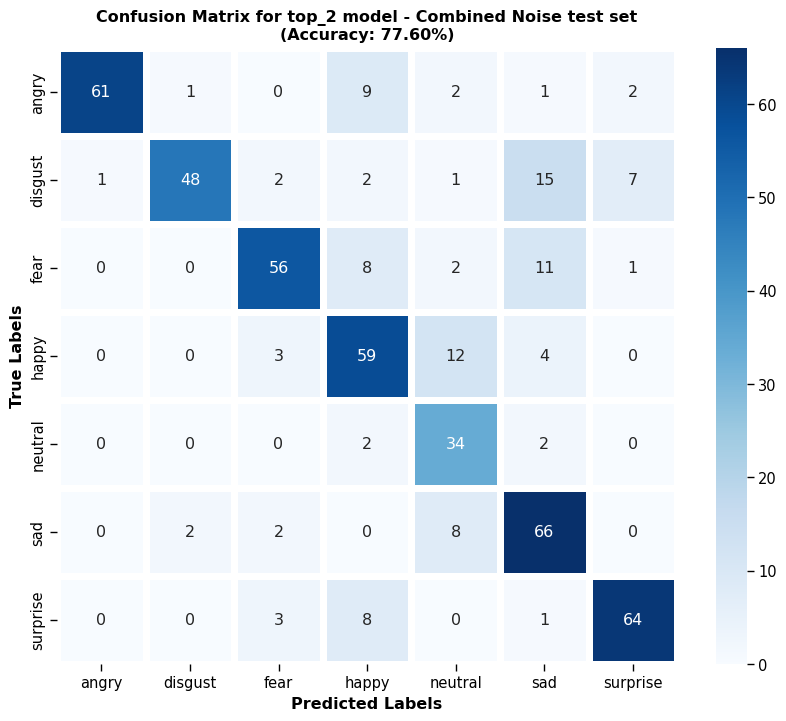


Evaluating top_2 model on Time Stretched dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Time Stretched: 100%|██████████| 250/250 [00:29<00:00,  8.47it/s, loss=0.370, accuracy=0.776]



=== Results for Time Stretched ===
Final accuracy: 77.6000%

Classification Report for top_2 model on Time Stretched test set::
              precision    recall  f1-score   support

       angry       0.90      0.95      0.92        38
     disgust       0.96      0.68      0.80        38
        fear       0.79      0.85      0.81        39
       happy       0.63      0.85      0.73        39
     neutral       0.62      0.68      0.65        19
         sad       0.95      0.49      0.64        39
    surprise       0.71      0.89      0.79        38

    accuracy                           0.78       250
   macro avg       0.79      0.77      0.76       250
weighted avg       0.81      0.78      0.77       250



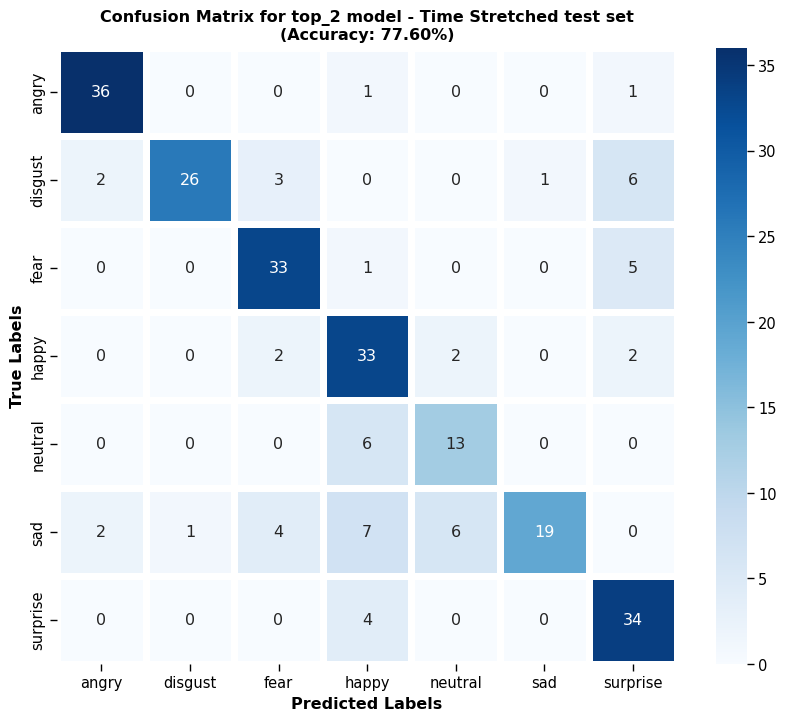


Evaluating top_2 model on SpecAugment dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing SpecAugment: 100%|██████████| 250/250 [00:23<00:00, 10.65it/s, loss=0.370, accuracy=0.892]



=== Results for SpecAugment ===
Final accuracy: 89.2000%

Classification Report for top_2 model on SpecAugment test set::
              precision    recall  f1-score   support

       angry       0.97      0.95      0.96        38
     disgust       0.92      0.87      0.89        38
        fear       0.86      0.95      0.90        39
       happy       0.94      0.85      0.89        39
     neutral       0.67      0.95      0.78        19
         sad       1.00      0.74      0.85        39
    surprise       0.86      0.97      0.91        38

    accuracy                           0.89       250
   macro avg       0.89      0.90      0.89       250
weighted avg       0.91      0.89      0.89       250



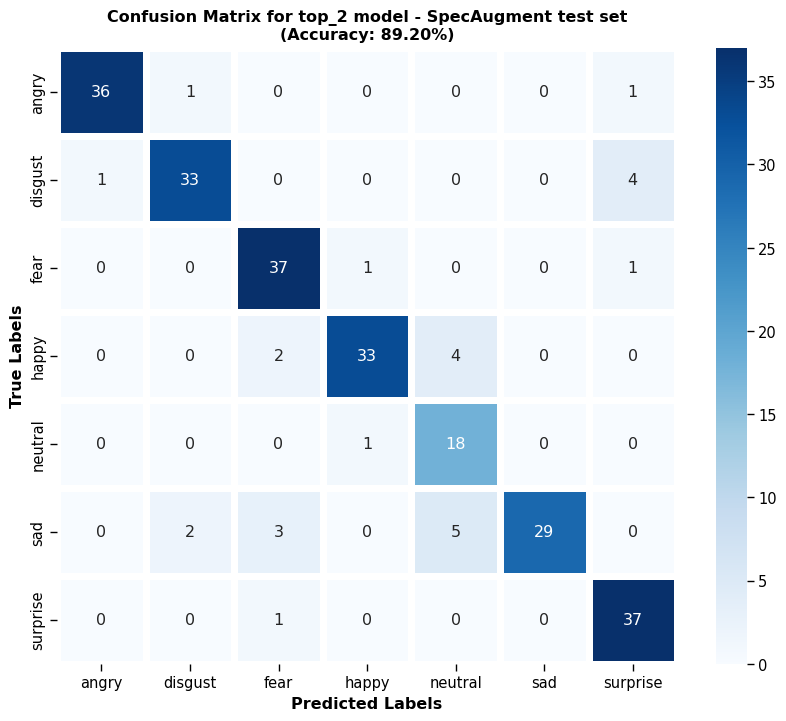


Evaluating top_2 model on Combined Time Stretch dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined Time Stretch: 100%|██████████| 500/500 [00:58<00:00,  8.60it/s, loss=0.370, accuracy=0.838]



=== Results for Combined Time Stretch ===
Final accuracy: 83.8000%

Classification Report for top_2 model on Combined Time Stretch test set::
              precision    recall  f1-score   support

       angry       0.94      0.95      0.94        76
     disgust       0.94      0.76      0.84        76
        fear       0.83      0.90      0.86        78
       happy       0.76      0.85      0.80        78
     neutral       0.67      0.84      0.74        38
         sad       0.98      0.64      0.78        78
    surprise       0.78      0.93      0.85        76

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.83       500
weighted avg       0.85      0.84      0.84       500



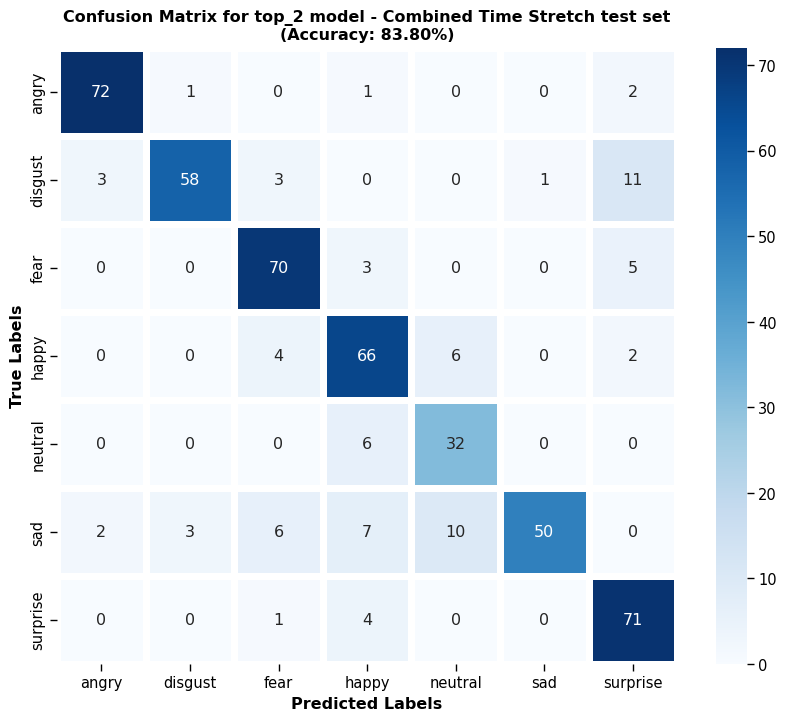


Evaluating top_2 model on Combined SpecAugment dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined SpecAugment: 100%|██████████| 500/500 [00:47<00:00, 10.47it/s, loss=0.370, accuracy=0.896]



=== Results for Combined SpecAugment ===
Final accuracy: 89.6000%

Classification Report for top_2 model on Combined SpecAugment test set::
              precision    recall  f1-score   support

       angry       0.97      0.95      0.96        76
     disgust       0.92      0.86      0.88        76
        fear       0.87      0.95      0.91        78
       happy       0.94      0.85      0.89        78
     neutral       0.69      0.97      0.80        38
         sad       1.00      0.77      0.87        78
    surprise       0.86      0.97      0.91        76

    accuracy                           0.90       500
   macro avg       0.89      0.90      0.89       500
weighted avg       0.91      0.90      0.90       500



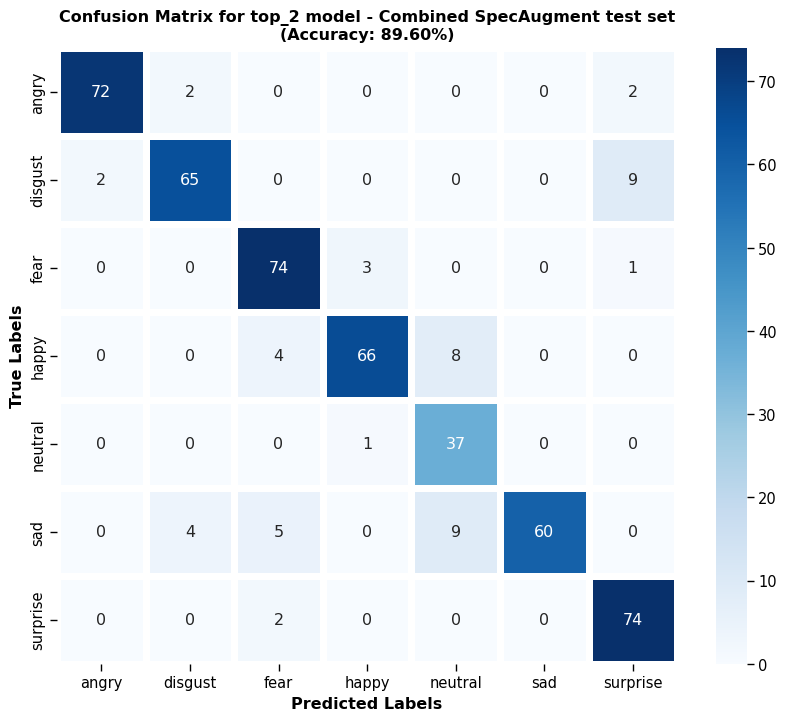


Evaluating top_2 model on Noise dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Noise: 100%|██████████| 250/250 [00:23<00:00, 10.66it/s, loss=0.372, accuracy=0.652]



=== Results for Noise ===
Final accuracy: 65.2000%

Classification Report for top_2 model on Noise test set::
              precision    recall  f1-score   support

       angry       1.00      0.66      0.79        38
     disgust       1.00      0.42      0.59        38
        fear       0.79      0.49      0.60        39
       happy       0.49      0.67      0.57        39
     neutral       0.47      0.79      0.59        19
         sad       0.51      0.90      0.65        39
    surprise       0.87      0.71      0.78        38

    accuracy                           0.65       250
   macro avg       0.73      0.66      0.65       250
weighted avg       0.75      0.65      0.66       250



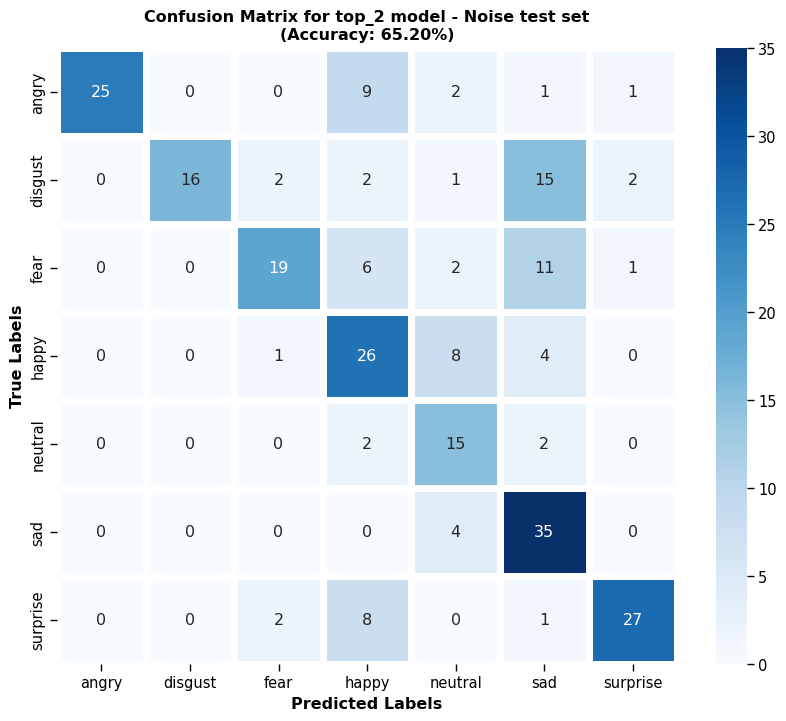


Evaluating top_2 model on NCP dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing NCP: 100%|██████████| 250/250 [00:16<00:00, 15.61it/s, loss=0.076, accuracy=0.516]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 


=== Results for NCP ===
Final accuracy: 51.6000%

Classification Report for top_2 model on NCP test set::
              precision    recall  f1-score   support

       angry       0.71      0.73      0.72        41
     disgust       0.87      0.32      0.46        41
        fear       0.38      0.14      0.20        43
       happy       0.36      0.79      0.49        42
     neutral       0.00      0.00      0.00         0
         sad       0.85      0.26      0.40        42
    surprise       0.58      0.88      0.70        41

    accuracy                           0.52       250
   macro avg       0.53      0.44      0.43       250
weighted avg       0.62      0.52      0.49       250



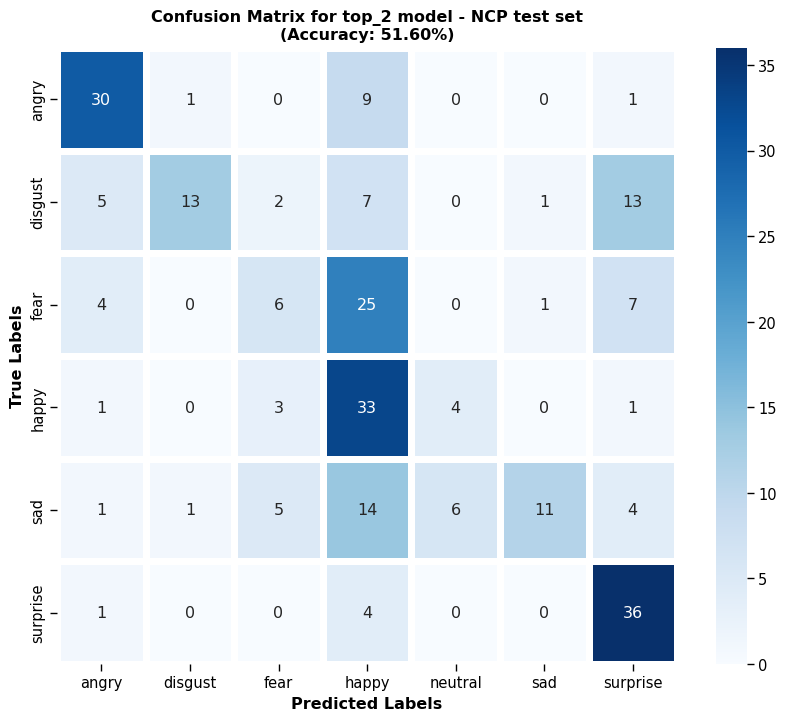


Evaluating top_2 model on Combined NCP dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined NCP: 100%|██████████| 500/500 [00:48<00:00, 10.35it/s, loss=0.076, accuracy=0.696]



=== Results for Combined NCP ===
Final accuracy: 69.6000%

Classification Report for top_2 model on Combined NCP test set::
              precision    recall  f1-score   support

       angry       0.83      0.81      0.82        79
     disgust       0.87      0.59      0.71        79
        fear       0.73      0.54      0.62        82
       happy       0.51      0.80      0.62        81
     neutral       0.50      1.00      0.67        19
         sad       0.92      0.44      0.60        81
    surprise       0.70      0.92      0.80        79

    accuracy                           0.70       500
   macro avg       0.72      0.73      0.69       500
weighted avg       0.75      0.70      0.69       500



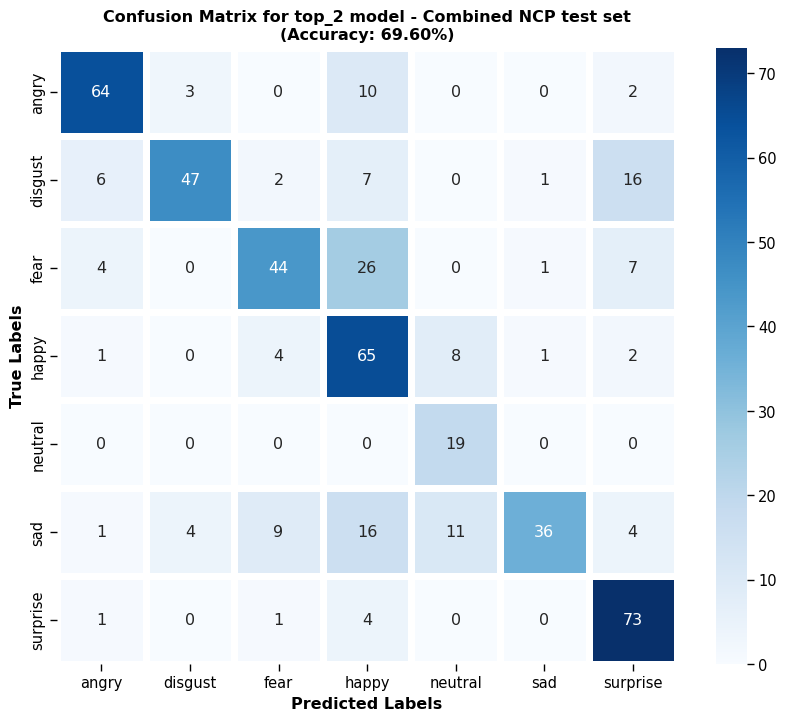


Evaluating top_2 model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:23<00:00, 10.70it/s, loss=0.302, accuracy=0.900]



=== Results for Clean ===
Final accuracy: 90.0000%

Classification Report for top_2 model on Clean test set::
              precision    recall  f1-score   support

       angry       0.97      0.95      0.96        38
     disgust       0.91      0.84      0.88        38
        fear       0.88      0.95      0.91        39
       happy       0.94      0.85      0.89        39
     neutral       0.70      1.00      0.83        19
         sad       1.00      0.79      0.89        39
    surprise       0.86      0.97      0.91        38

    accuracy                           0.90       250
   macro avg       0.90      0.91      0.90       250
weighted avg       0.91      0.90      0.90       250



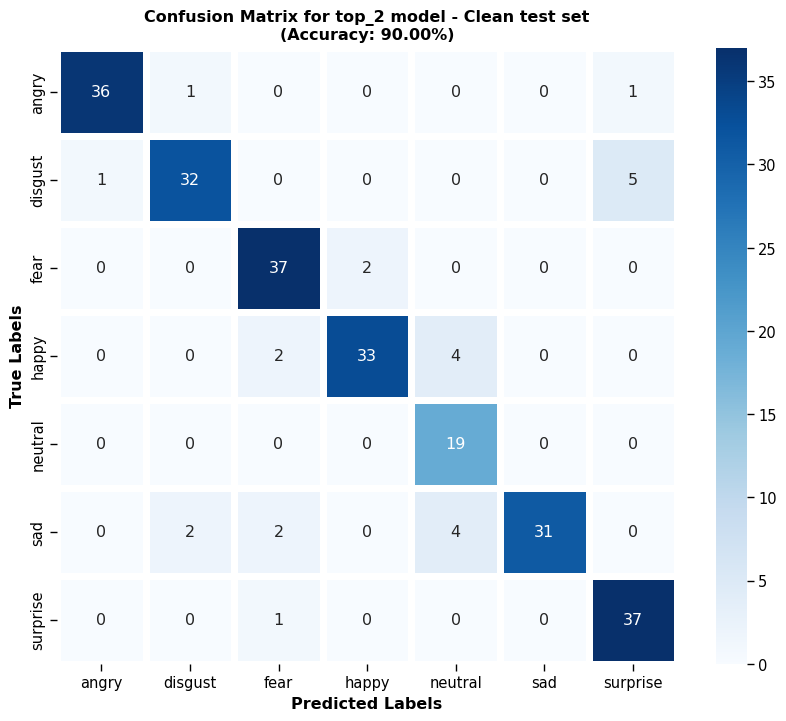


Evaluating top_3 model on Combined Noise dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined Noise: 100%|██████████| 500/500 [00:48<00:00, 10.35it/s, loss=2.385, accuracy=0.742]



=== Results for Combined Noise ===
Final accuracy: 74.2000%

Classification Report for top_3 model on Combined Noise test set::
              precision    recall  f1-score   support

       angry       0.91      0.89      0.90        76
     disgust       1.00      0.63      0.77        76
        fear       0.81      0.73      0.77        78
       happy       0.77      0.56      0.65        78
     neutral       0.40      0.89      0.56        38
         sad       0.59      0.78      0.67        78
    surprise       0.94      0.78      0.85        76

    accuracy                           0.74       500
   macro avg       0.78      0.75      0.74       500
weighted avg       0.80      0.74      0.75       500



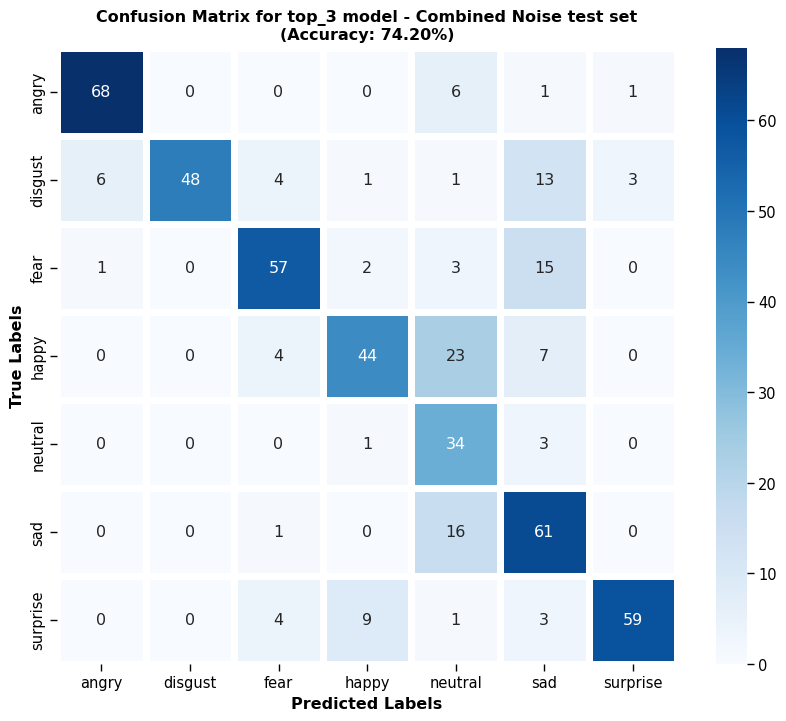


Evaluating top_3 model on Time Stretched dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Time Stretched: 100%|██████████| 250/250 [00:28<00:00,  8.83it/s, loss=0.702, accuracy=0.764]



=== Results for Time Stretched ===
Final accuracy: 76.4000%

Classification Report for top_3 model on Time Stretched test set::
              precision    recall  f1-score   support

       angry       0.75      0.95      0.84        38
     disgust       1.00      0.66      0.79        38
        fear       0.84      0.82      0.83        39
       happy       0.70      0.77      0.73        39
     neutral       0.55      0.89      0.68        19
         sad       0.89      0.44      0.59        39
    surprise       0.74      0.89      0.81        38

    accuracy                           0.76       250
   macro avg       0.78      0.77      0.75       250
weighted avg       0.80      0.76      0.76       250



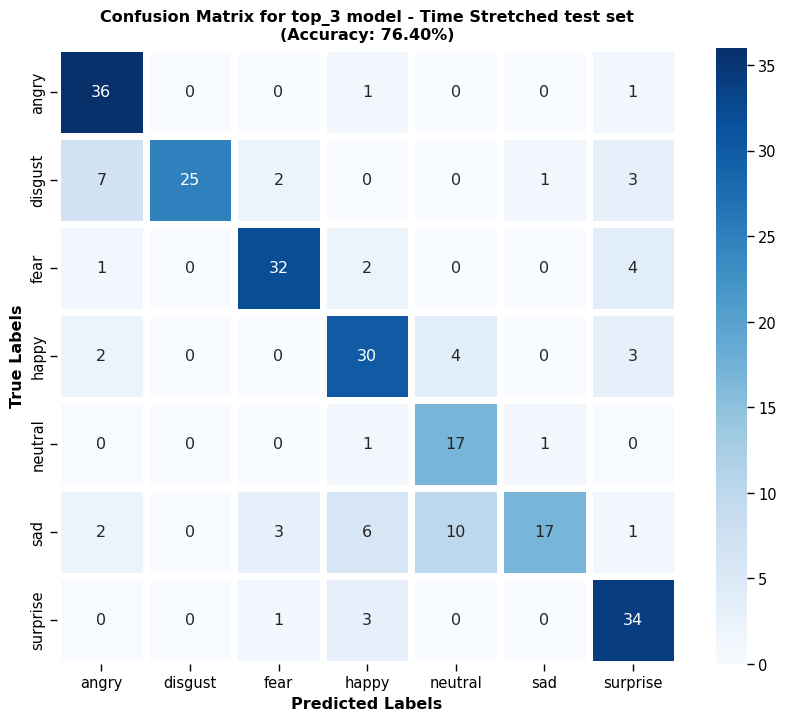


Evaluating top_3 model on SpecAugment dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing SpecAugment: 100%|██████████| 250/250 [00:24<00:00, 10.29it/s, loss=0.709, accuracy=0.856]



=== Results for SpecAugment ===
Final accuracy: 85.6000%

Classification Report for top_3 model on SpecAugment test set::
              precision    recall  f1-score   support

       angry       0.86      0.97      0.91        38
     disgust       1.00      0.79      0.88        38
        fear       0.88      0.95      0.91        39
       happy       0.91      0.77      0.83        39
     neutral       0.51      0.95      0.67        19
         sad       0.96      0.69      0.81        39
    surprise       0.90      0.92      0.91        38

    accuracy                           0.86       250
   macro avg       0.86      0.86      0.85       250
weighted avg       0.89      0.86      0.86       250



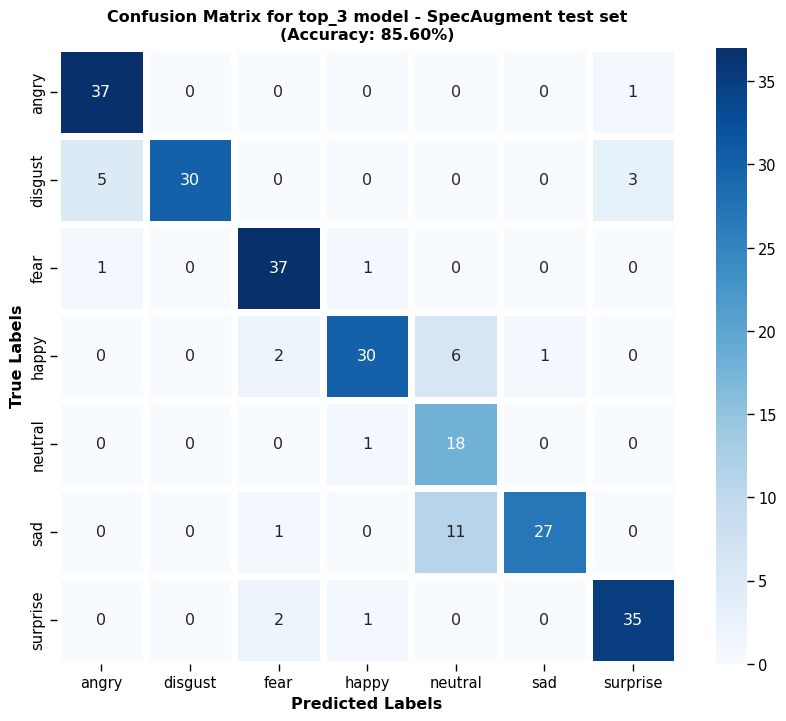


Evaluating top_3 model on Combined Time Stretch dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined Time Stretch: 100%|██████████| 500/500 [00:57<00:00,  8.64it/s, loss=0.702, accuracy=0.816]



=== Results for Combined Time Stretch ===
Final accuracy: 81.6000%

Classification Report for top_3 model on Combined Time Stretch test set::
              precision    recall  f1-score   support

       angry       0.83      0.96      0.89        76
     disgust       1.00      0.76      0.87        76
        fear       0.86      0.88      0.87        78
       happy       0.79      0.77      0.78        78
     neutral       0.53      0.92      0.67        38
         sad       0.94      0.56      0.70        78
    surprise       0.81      0.91      0.86        76

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.81       500
weighted avg       0.85      0.82      0.82       500



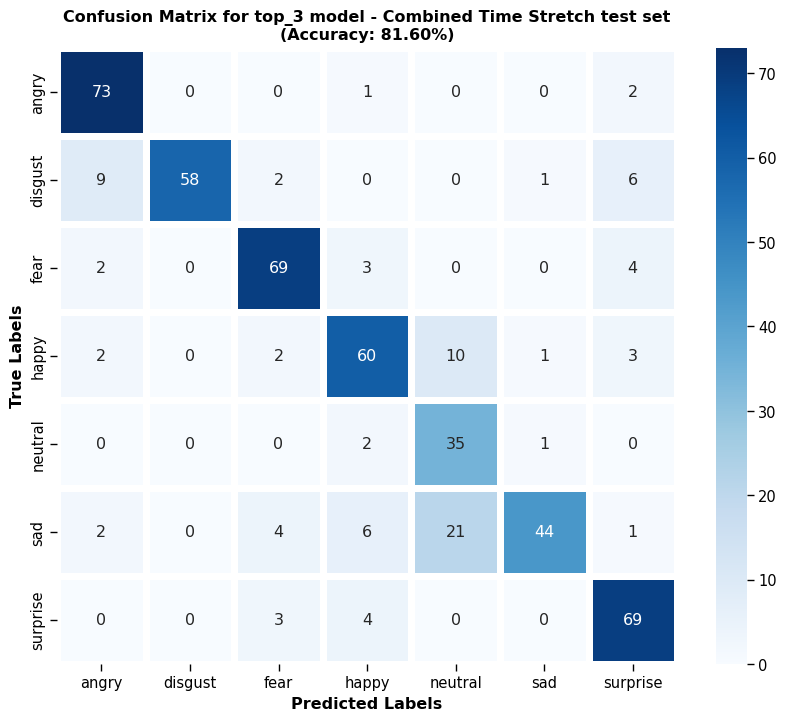


Evaluating top_3 model on Combined SpecAugment dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined SpecAugment: 100%|██████████| 500/500 [00:47<00:00, 10.48it/s, loss=0.709, accuracy=0.862]



=== Results for Combined SpecAugment ===
Final accuracy: 86.2000%

Classification Report for top_3 model on Combined SpecAugment test set::
              precision    recall  f1-score   support

       angry       0.89      0.97      0.93        76
     disgust       1.00      0.83      0.91        76
        fear       0.88      0.95      0.91        78
       happy       0.91      0.77      0.83        78
     neutral       0.51      0.95      0.67        38
         sad       0.96      0.69      0.81        78
    surprise       0.90      0.92      0.91        76

    accuracy                           0.86       500
   macro avg       0.87      0.87      0.85       500
weighted avg       0.89      0.86      0.87       500



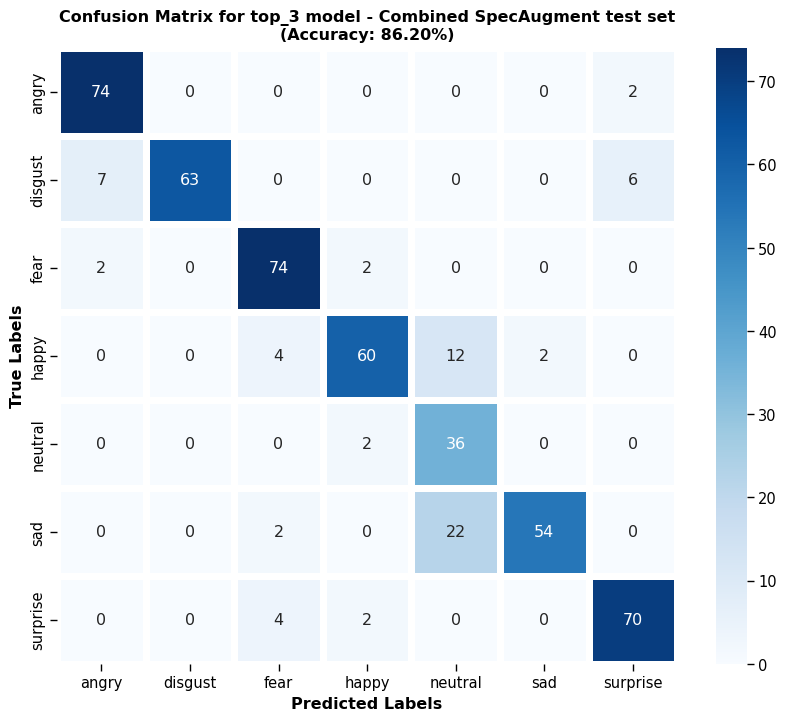


Evaluating top_3 model on Noise dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Noise: 100%|██████████| 250/250 [00:23<00:00, 10.63it/s, loss=2.385, accuracy=0.616]



=== Results for Noise ===
Final accuracy: 61.6000%

Classification Report for top_3 model on Noise test set::
              precision    recall  f1-score   support

       angry       0.89      0.82      0.85        38
     disgust       1.00      0.39      0.57        38
        fear       0.71      0.51      0.60        39
       happy       0.58      0.36      0.44        39
     neutral       0.33      0.84      0.47        19
         sad       0.45      0.87      0.60        39
    surprise       1.00      0.63      0.77        38

    accuracy                           0.62       250
   macro avg       0.71      0.63      0.61       250
weighted avg       0.74      0.62      0.62       250



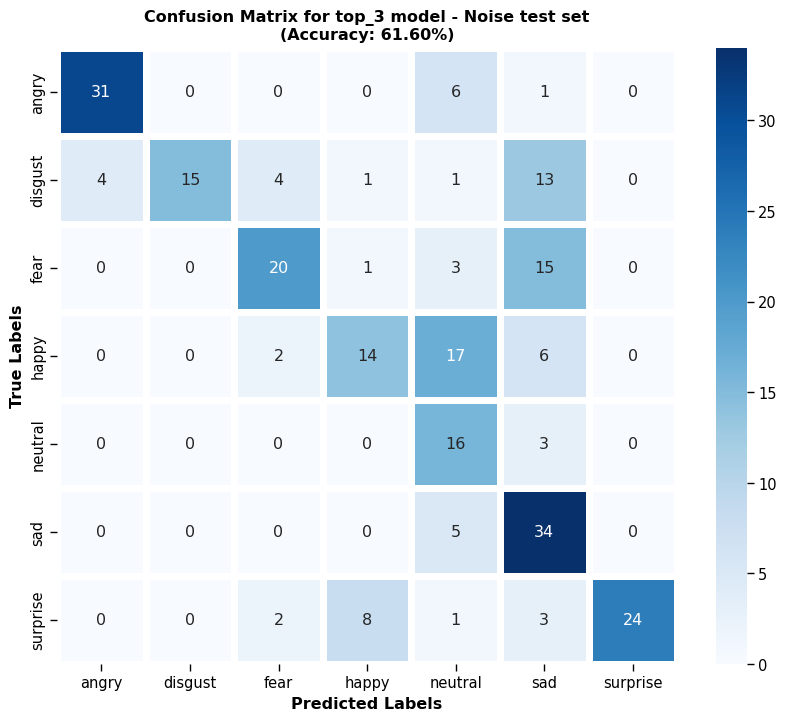


Evaluating top_3 model on NCP dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing NCP: 100%|██████████| 250/250 [00:16<00:00, 15.55it/s, loss=0.015, accuracy=0.488]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 


=== Results for NCP ===
Final accuracy: 48.8000%

Classification Report for top_3 model on NCP test set::
              precision    recall  f1-score   support

       angry       0.64      0.85      0.73        41
     disgust       0.89      0.39      0.54        41
        fear       0.55      0.14      0.22        43
       happy       0.31      0.62      0.42        42
     neutral       0.00      0.00      0.00         0
         sad       0.69      0.26      0.38        42
    surprise       0.64      0.68      0.66        41

    accuracy                           0.49       250
   macro avg       0.53      0.42      0.42       250
weighted avg       0.62      0.49      0.49       250



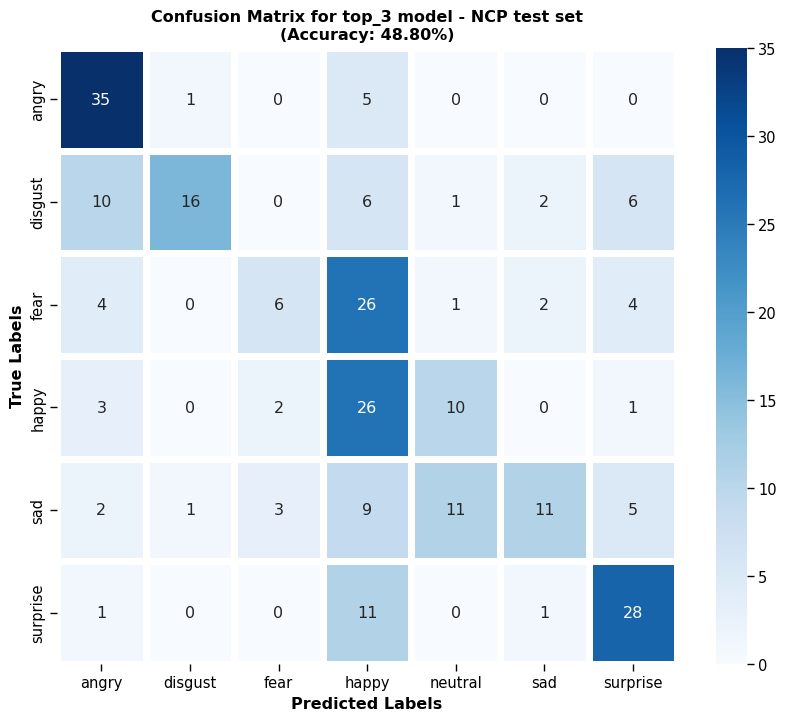


Evaluating top_3 model on Combined NCP dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined NCP: 100%|██████████| 500/500 [00:48<00:00, 10.37it/s, loss=0.015, accuracy=0.688]



=== Results for Combined NCP ===
Final accuracy: 68.8000%

Classification Report for top_3 model on Combined NCP test set::
              precision    recall  f1-score   support

       angry       0.77      0.91      0.83        79
     disgust       0.93      0.65      0.76        79
        fear       0.83      0.54      0.65        82
       happy       0.48      0.69      0.57        81
     neutral       0.34      0.95      0.50        19
         sad       0.87      0.49      0.63        81
    surprise       0.77      0.80      0.78        79

    accuracy                           0.69       500
   macro avg       0.71      0.72      0.67       500
weighted avg       0.76      0.69      0.70       500



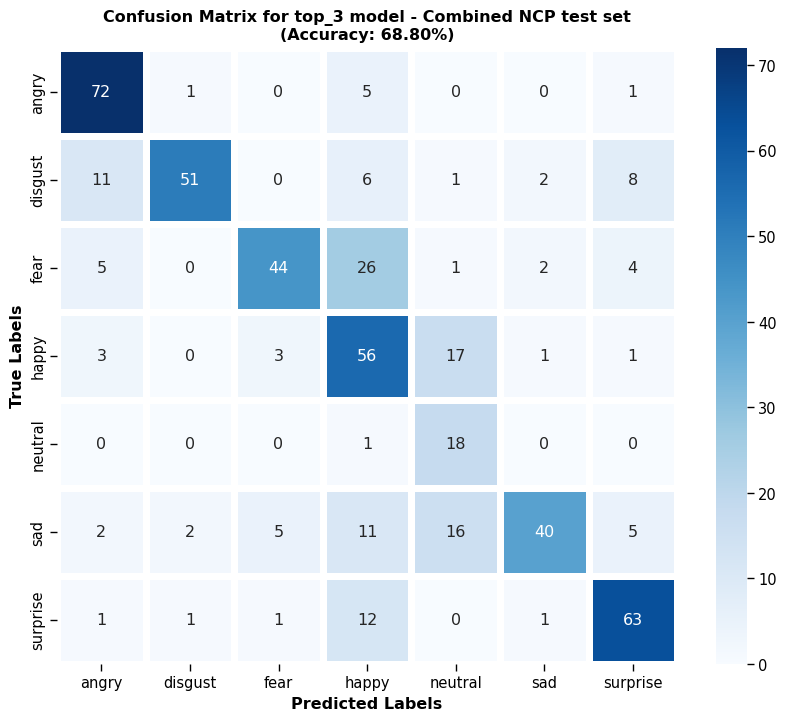


Evaluating top_3 model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:23<00:00, 10.74it/s, loss=0.616, accuracy=0.868]



=== Results for Clean ===
Final accuracy: 86.8000%

Classification Report for top_3 model on Clean test set::
              precision    recall  f1-score   support

       angry       0.93      0.97      0.95        38
     disgust       1.00      0.87      0.93        38
        fear       0.88      0.95      0.91        39
       happy       0.91      0.77      0.83        39
     neutral       0.51      0.95      0.67        19
         sad       0.96      0.69      0.81        39
    surprise       0.90      0.92      0.91        38

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.86       250
weighted avg       0.90      0.87      0.87       250



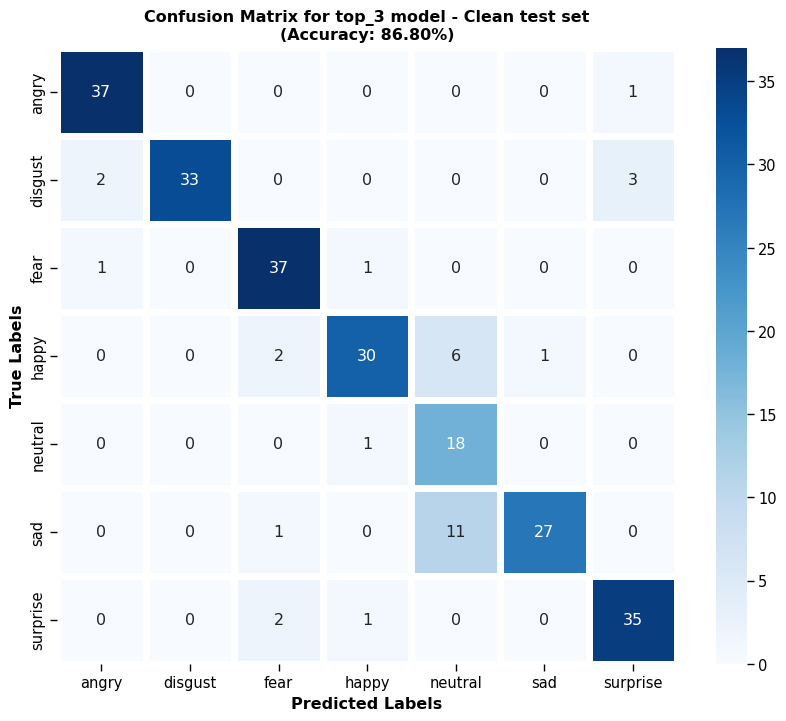


Evaluating top_4 model on Combined Noise dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined Noise: 100%|██████████| 500/500 [00:48<00:00, 10.35it/s, loss=3.310, accuracy=0.722]



=== Results for Combined Noise ===
Final accuracy: 72.2000%

Classification Report for top_4 model on Combined Noise test set::
              precision    recall  f1-score   support

       angry       0.83      0.84      0.84        76
     disgust       1.00      0.63      0.77        76
        fear       0.88      0.67      0.76        78
       happy       0.85      0.51      0.64        78
     neutral       0.36      0.95      0.52        38
         sad       0.58      0.77      0.66        78
    surprise       0.94      0.80      0.87        76

    accuracy                           0.72       500
   macro avg       0.78      0.74      0.72       500
weighted avg       0.81      0.72      0.74       500



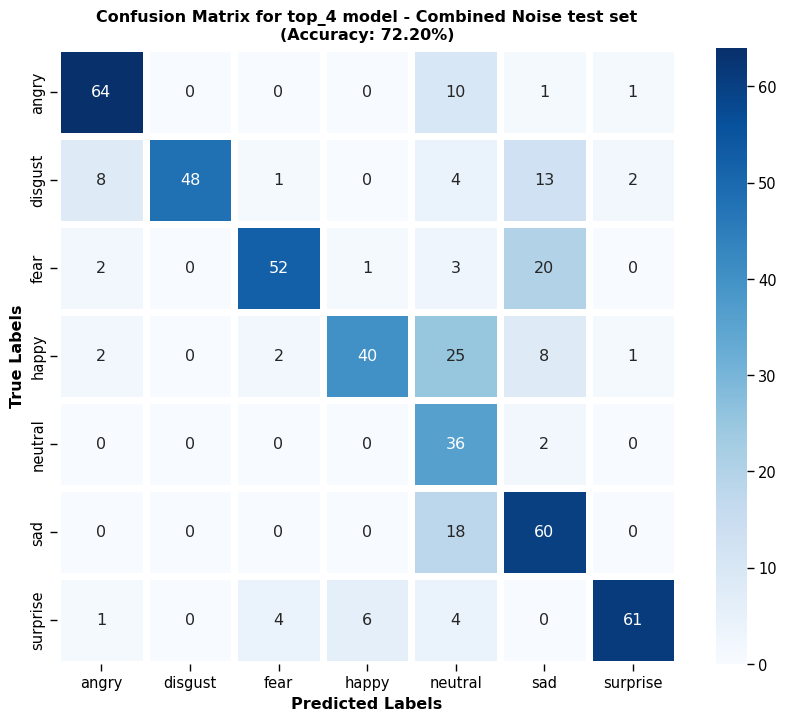


Evaluating top_4 model on Time Stretched dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Time Stretched: 100%|██████████| 250/250 [00:28<00:00,  8.83it/s, loss=1.737, accuracy=0.764]



=== Results for Time Stretched ===
Final accuracy: 76.4000%

Classification Report for top_4 model on Time Stretched test set::
              precision    recall  f1-score   support

       angry       0.73      0.95      0.83        38
     disgust       1.00      0.63      0.77        38
        fear       0.91      0.74      0.82        39
       happy       0.68      0.82      0.74        39
     neutral       0.53      0.95      0.68        19
         sad       0.76      0.49      0.59        39
    surprise       0.85      0.87      0.86        38

    accuracy                           0.76       250
   macro avg       0.78      0.78      0.76       250
weighted avg       0.80      0.76      0.76       250



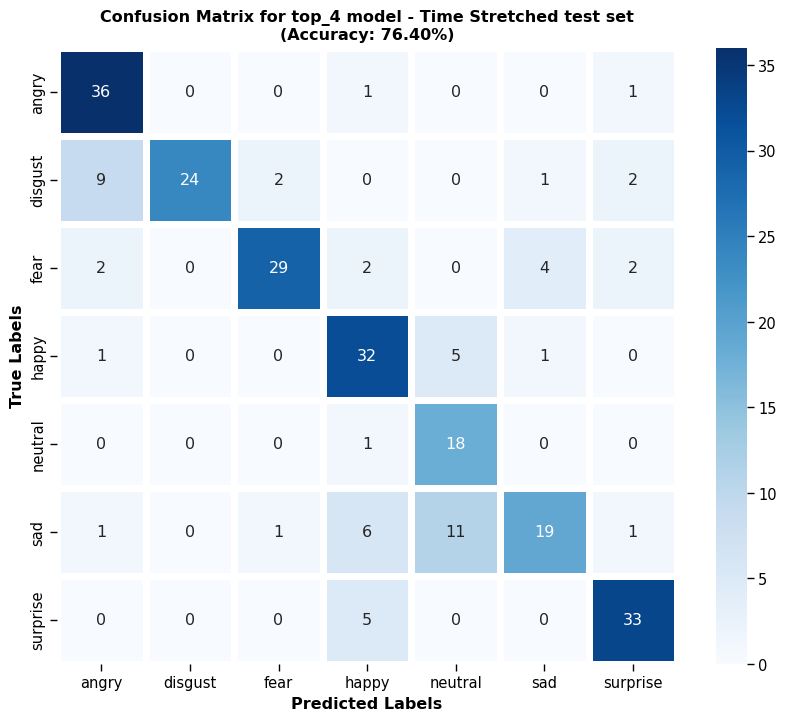


Evaluating top_4 model on SpecAugment dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing SpecAugment: 100%|██████████| 250/250 [00:24<00:00, 10.24it/s, loss=1.730, accuracy=0.872]



=== Results for SpecAugment ===
Final accuracy: 87.2000%

Classification Report for top_4 model on SpecAugment test set::
              precision    recall  f1-score   support

       angry       0.88      0.97      0.93        38
     disgust       1.00      0.89      0.94        38
        fear       0.95      0.95      0.95        39
       happy       0.97      0.74      0.84        39
     neutral       0.50      1.00      0.67        19
         sad       0.96      0.67      0.79        39
    surprise       0.90      0.95      0.92        38

    accuracy                           0.87       250
   macro avg       0.88      0.88      0.86       250
weighted avg       0.91      0.87      0.88       250



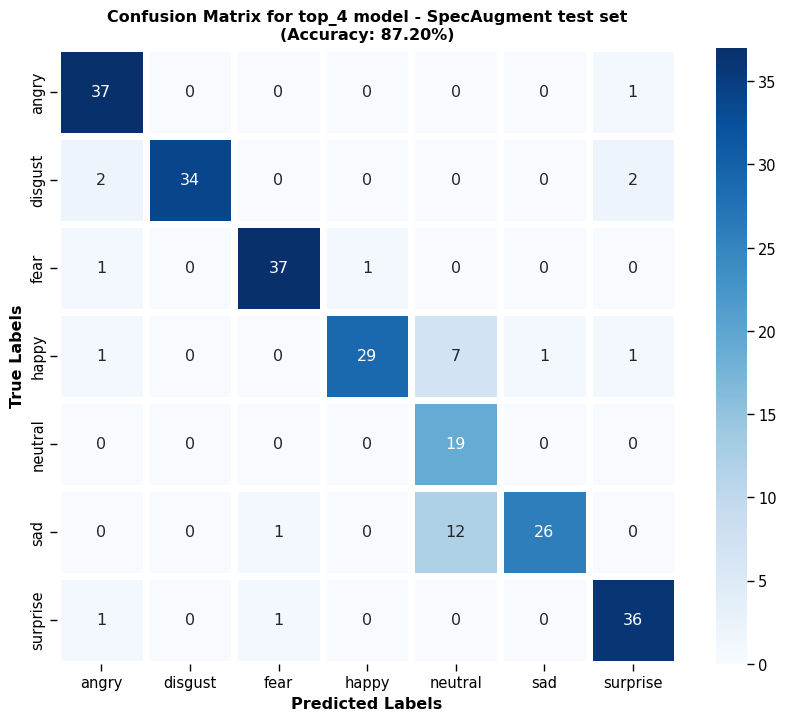


Evaluating top_4 model on Combined Time Stretch dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined Time Stretch: 100%|██████████| 500/500 [00:58<00:00,  8.57it/s, loss=1.737, accuracy=0.822]



=== Results for Combined Time Stretch ===
Final accuracy: 82.2000%

Classification Report for top_4 model on Combined Time Stretch test set::
              precision    recall  f1-score   support

       angry       0.80      0.96      0.87        76
     disgust       1.00      0.76      0.87        76
        fear       0.94      0.83      0.88        78
       happy       0.79      0.78      0.79        78
     neutral       0.53      0.97      0.69        38
         sad       0.86      0.62      0.72        78
    surprise       0.87      0.91      0.89        76

    accuracy                           0.82       500
   macro avg       0.83      0.83      0.81       500
weighted avg       0.85      0.82      0.82       500



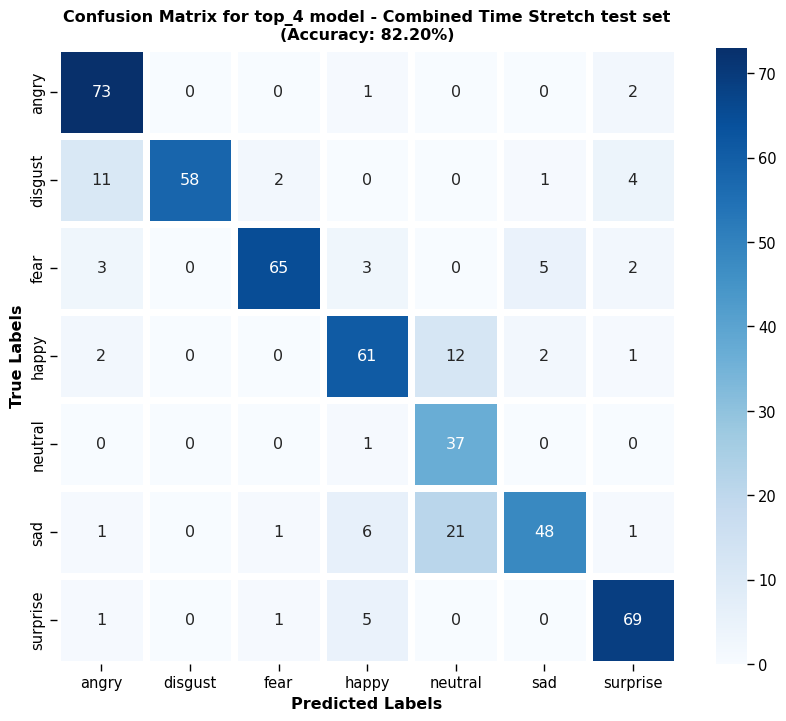


Evaluating top_4 model on Combined SpecAugment dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined SpecAugment: 100%|██████████| 500/500 [00:47<00:00, 10.48it/s, loss=1.730, accuracy=0.876]



=== Results for Combined SpecAugment ===
Final accuracy: 87.6000%

Classification Report for top_4 model on Combined SpecAugment test set::
              precision    recall  f1-score   support

       angry       0.88      0.97      0.93        76
     disgust       1.00      0.89      0.94        76
        fear       0.96      0.94      0.95        78
       happy       0.97      0.74      0.84        78
     neutral       0.51      1.00      0.68        38
         sad       0.95      0.71      0.81        78
    surprise       0.90      0.95      0.92        76

    accuracy                           0.88       500
   macro avg       0.88      0.89      0.87       500
weighted avg       0.91      0.88      0.88       500



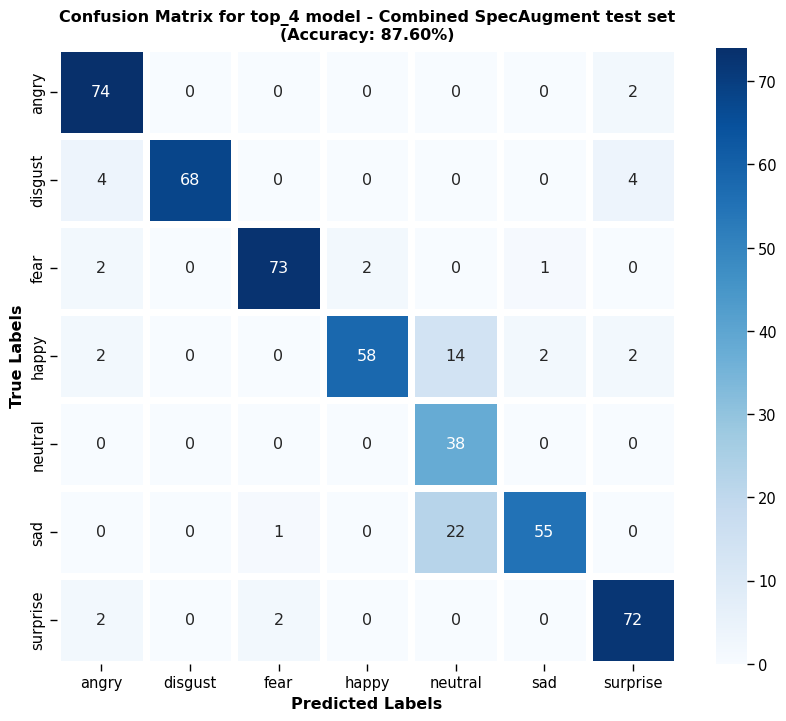


Evaluating top_4 model on Noise dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Noise: 100%|██████████| 250/250 [00:23<00:00, 10.65it/s, loss=3.310, accuracy=0.564]



=== Results for Noise ===
Final accuracy: 56.4000%

Classification Report for top_4 model on Noise test set::
              precision    recall  f1-score   support

       angry       0.77      0.71      0.74        38
     disgust       1.00      0.37      0.54        38
        fear       0.73      0.41      0.52        39
       happy       0.65      0.28      0.39        39
     neutral       0.27      0.89      0.41        19
         sad       0.42      0.79      0.55        39
    surprise       1.00      0.66      0.79        38

    accuracy                           0.56       250
   macro avg       0.69      0.59      0.56       250
weighted avg       0.72      0.56      0.58       250



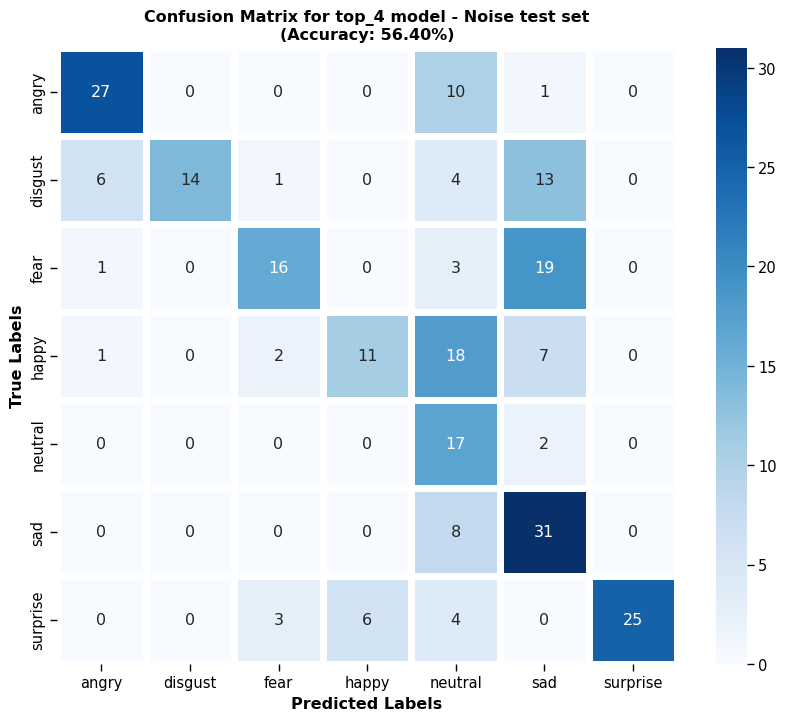


Evaluating top_4 model on NCP dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing NCP: 100%|██████████| 250/250 [00:16<00:00, 15.56it/s, loss=0.004, accuracy=0.456]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 


=== Results for NCP ===
Final accuracy: 45.6000%

Classification Report for top_4 model on NCP test set::
              precision    recall  f1-score   support

       angry       0.46      0.83      0.59        41
     disgust       0.90      0.44      0.59        41
        fear       0.64      0.16      0.26        43
       happy       0.30      0.50      0.38        42
     neutral       0.00      0.00      0.00         0
         sad       0.79      0.26      0.39        42
    surprise       0.72      0.56      0.63        41

    accuracy                           0.46       250
   macro avg       0.54      0.39      0.41       250
weighted avg       0.63      0.46      0.47       250



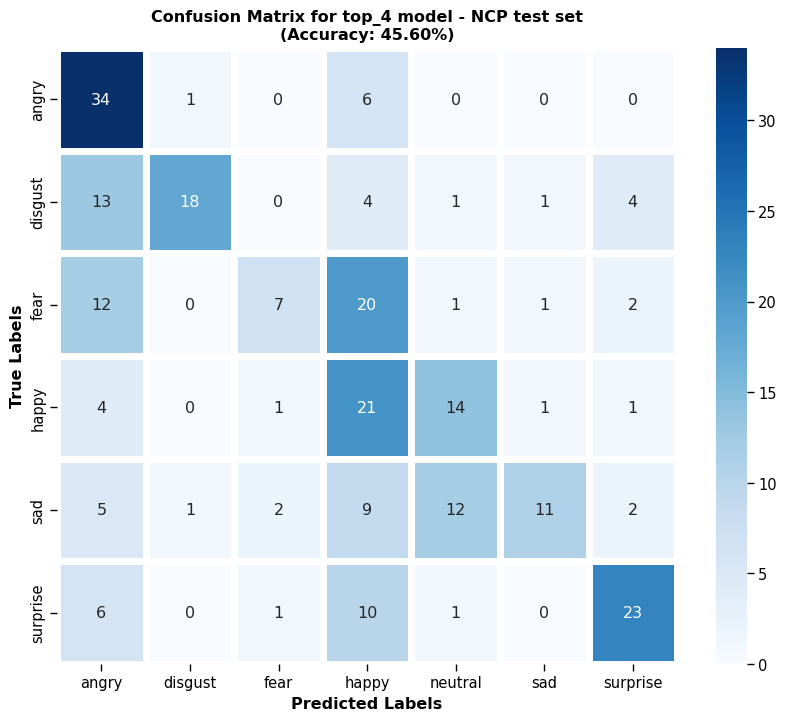


Evaluating top_4 model on Combined NCP dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined NCP: 100%|██████████| 500/500 [00:48<00:00, 10.39it/s, loss=0.004, accuracy=0.664]



=== Results for Combined NCP ===
Final accuracy: 66.4000%

Classification Report for top_4 model on Combined NCP test set::
              precision    recall  f1-score   support

       angry       0.62      0.87      0.72        79
     disgust       0.95      0.68      0.79        79
        fear       0.86      0.54      0.66        82
       happy       0.49      0.60      0.54        81
     neutral       0.29      1.00      0.45        19
         sad       0.89      0.48      0.62        81
    surprise       0.83      0.73      0.78        79

    accuracy                           0.66       500
   macro avg       0.70      0.70      0.65       500
weighted avg       0.75      0.66      0.68       500



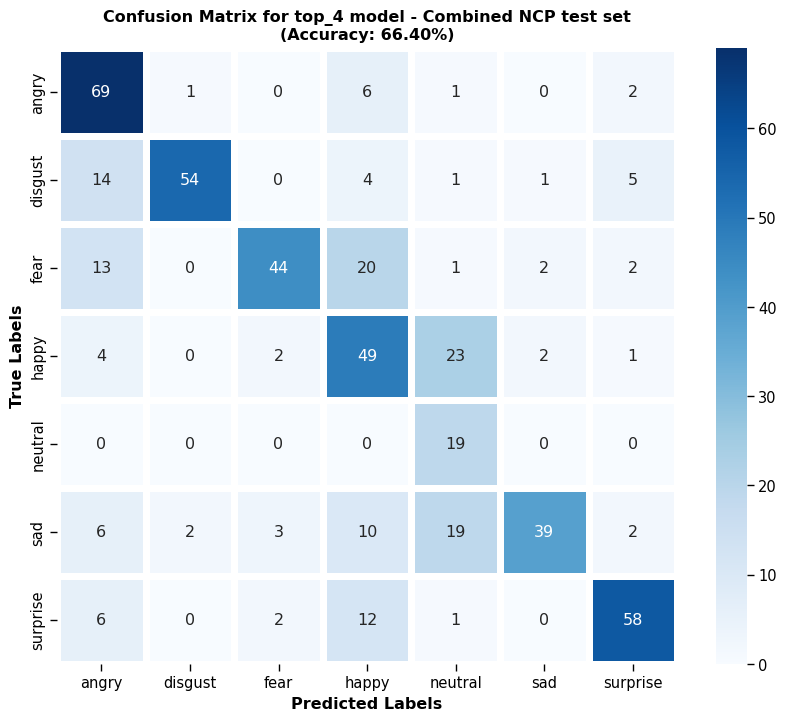


Evaluating top_4 model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:23<00:00, 10.76it/s, loss=1.693, accuracy=0.880]



=== Results for Clean ===
Final accuracy: 88.0000%

Classification Report for top_4 model on Clean test set::
              precision    recall  f1-score   support

       angry       0.88      0.97      0.93        38
     disgust       1.00      0.89      0.94        38
        fear       0.97      0.92      0.95        39
       happy       0.97      0.74      0.84        39
     neutral       0.53      1.00      0.69        19
         sad       0.94      0.74      0.83        39
    surprise       0.90      0.95      0.92        38

    accuracy                           0.88       250
   macro avg       0.88      0.89      0.87       250
weighted avg       0.91      0.88      0.89       250



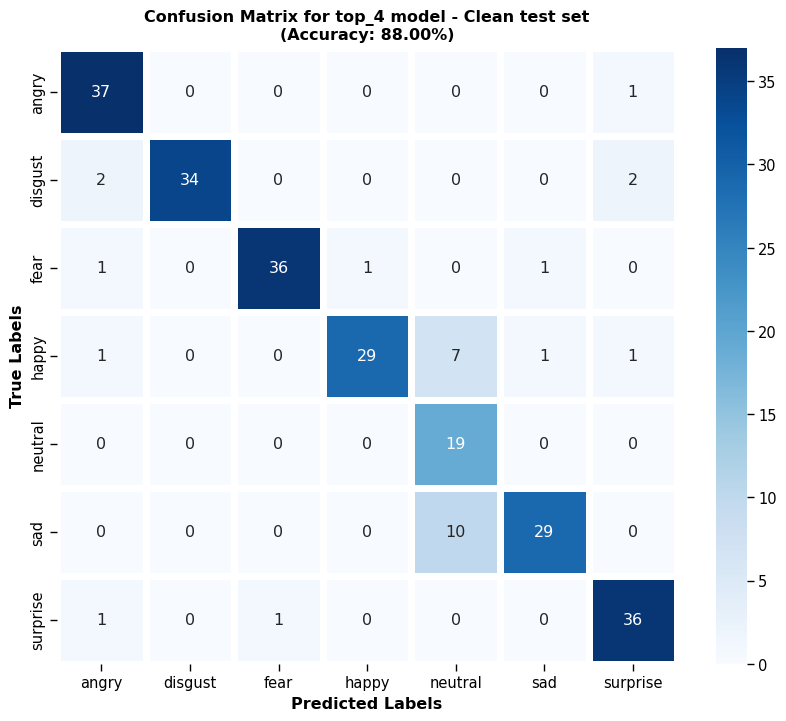

In [ ]:
results = {}

models_path = f"{BASE_DIR}/Augmentation/Augmented models"
for model_name in combined_models:
    # Load combined model
    model_path = f"{models_path}/{model_name}"
    model = HubertForSequenceClassification.from_pretrained(model_path)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
    model.to(device)
    # Evaluate on test sets
    for set_name, test_data in loaded_test_sets.items():
      print(f"\nEvaluating {model_name} model on {set_name} dataset...")
      accuracy, df_record = evaluate_test_set(
          model,
          model_name,
          test_data,
          set_name,
          device,
          feature_extractor
      )
      results[set_name] = {'accuracy': accuracy, 'record': df_record}

## 6. Performance Summary of All Models

### Evaluate singular models on all tesetsets


Evaluating NCP model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:22<00:00, 11.11it/s, loss=0.137, accuracy=0.776]



=== Results for Clean ===
Final accuracy: 77.6000%

Classification Report for NCP model on Clean test set:
              precision    recall  f1-score   support

       angry       0.94      0.89      0.92        38
     disgust       0.94      0.84      0.89        38
        fear       1.00      0.54      0.70        39
       happy       0.65      0.87      0.75        39
     neutral       0.45      1.00      0.62        19
         sad       0.86      0.46      0.60        39
    surprise       0.82      0.95      0.88        38

    accuracy                           0.78       250
   macro avg       0.81      0.79      0.77       250
weighted avg       0.84      0.78      0.77       250



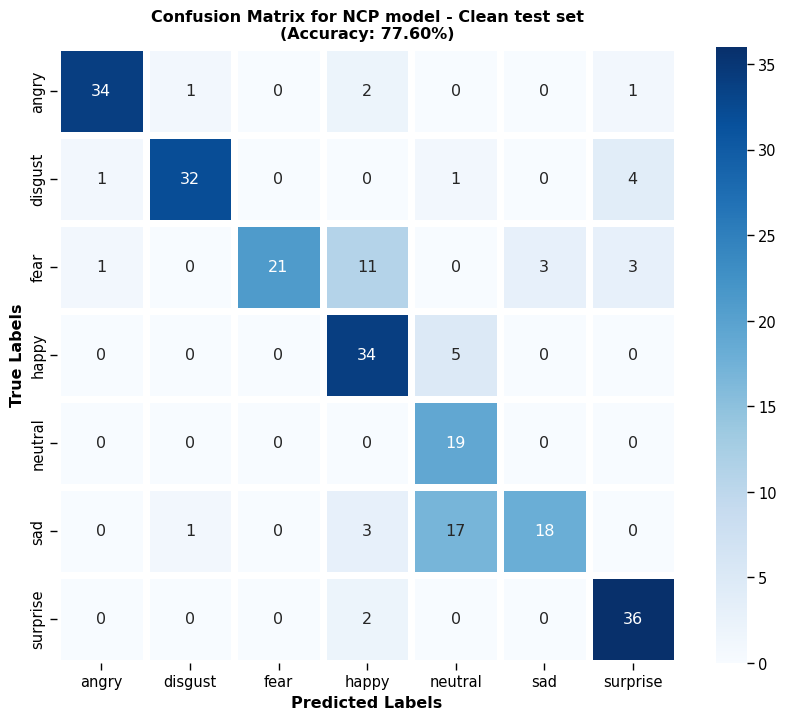


Evaluating Noise model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:23<00:00, 10.55it/s, loss=1.537, accuracy=0.756]



=== Results for Clean ===
Final accuracy: 75.6000%

Classification Report for Noise model on Clean test set:
              precision    recall  f1-score   support

       angry       0.83      0.89      0.86        38
     disgust       1.00      0.74      0.85        38
        fear       0.89      0.79      0.84        39
       happy       0.90      0.49      0.63        39
     neutral       0.38      1.00      0.55        19
         sad       0.85      0.56      0.68        39
    surprise       0.73      0.95      0.83        38

    accuracy                           0.76       250
   macro avg       0.80      0.78      0.75       250
weighted avg       0.83      0.76      0.76       250



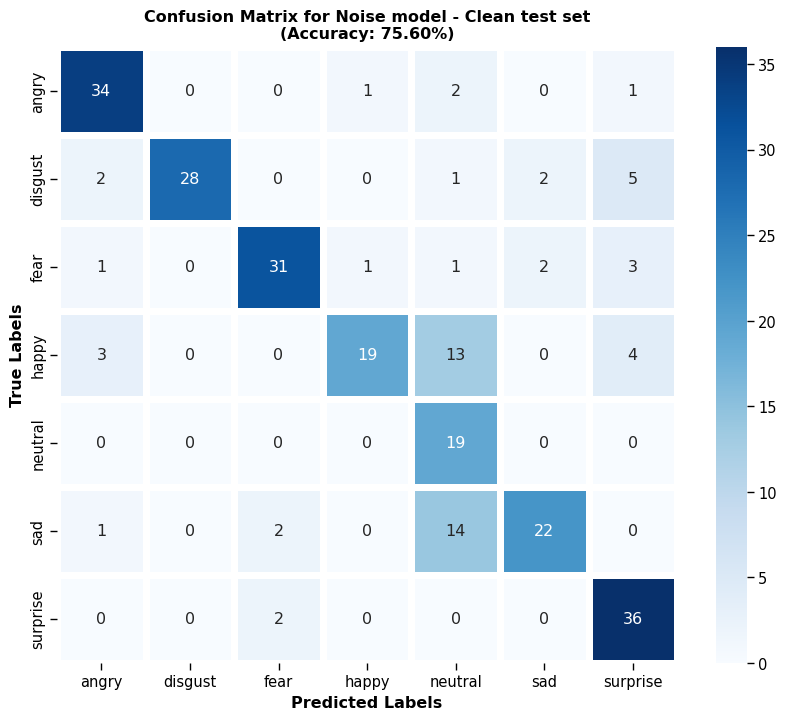


Evaluating specAugment model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:23<00:00, 10.55it/s, loss=1.314, accuracy=0.908]



=== Results for Clean ===
Final accuracy: 90.8000%

Classification Report for specAugment model on Clean test set:
              precision    recall  f1-score   support

       angry       0.97      0.92      0.95        38
     disgust       1.00      0.89      0.94        38
        fear       0.97      1.00      0.99        39
       happy       0.85      0.90      0.88        39
     neutral       0.64      0.95      0.77        19
         sad       0.94      0.85      0.89        39
    surprise       0.92      0.87      0.89        38

    accuracy                           0.91       250
   macro avg       0.90      0.91      0.90       250
weighted avg       0.92      0.91      0.91       250



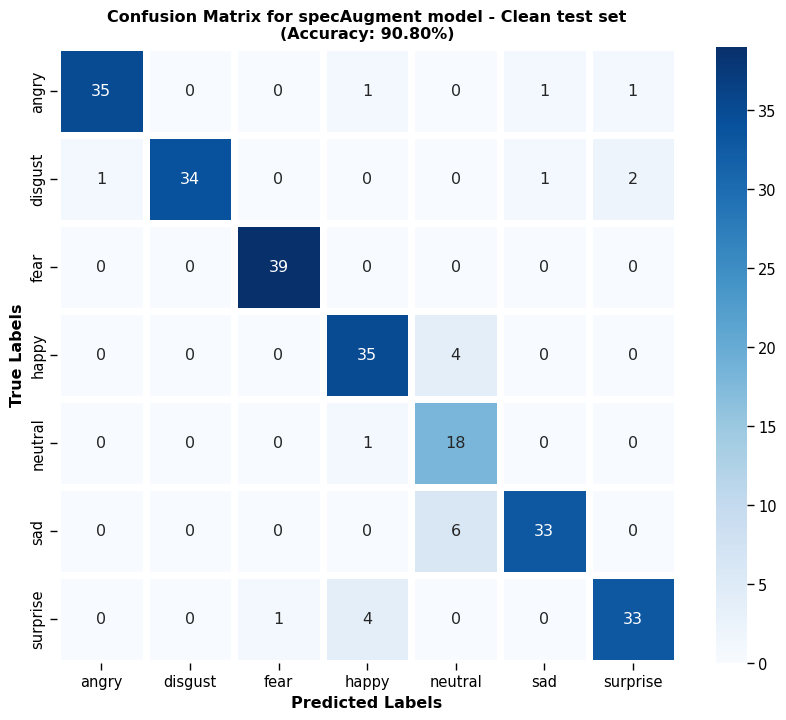


Evaluating Time-stretch model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:23<00:00, 10.47it/s, loss=0.422, accuracy=0.852]



=== Results for Clean ===
Final accuracy: 85.2000%

Classification Report for Time-stretch model on Clean test set:
              precision    recall  f1-score   support

       angry       0.90      0.92      0.91        38
     disgust       1.00      0.76      0.87        38
        fear       0.92      0.90      0.91        39
       happy       0.84      0.79      0.82        39
     neutral       0.61      0.89      0.72        19
         sad       0.94      0.77      0.85        39
    surprise       0.77      0.95      0.85        38

    accuracy                           0.85       250
   macro avg       0.85      0.86      0.85       250
weighted avg       0.87      0.85      0.85       250



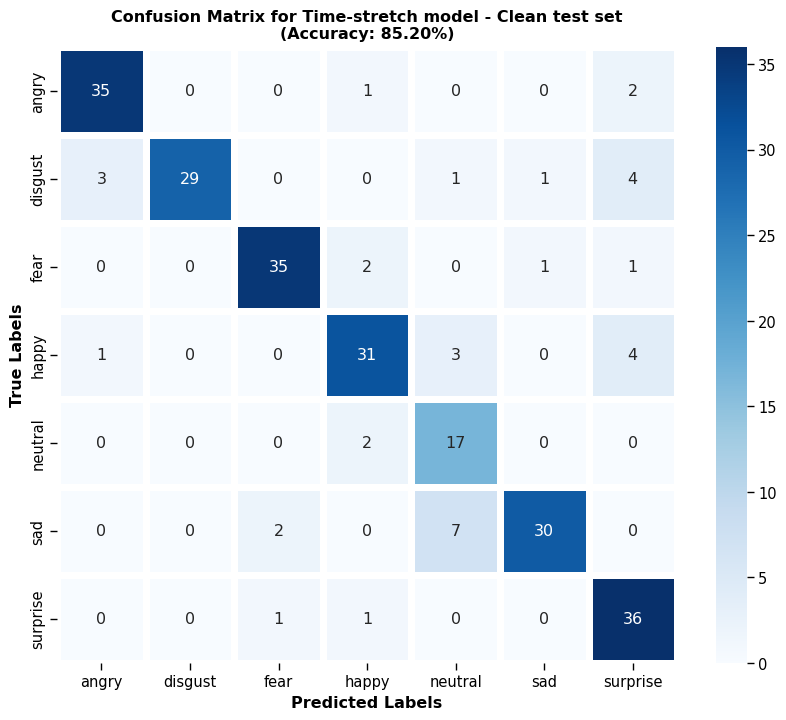

In [ ]:
results = {}

single_models = ["NCP", "Noise", "specAugment", "Time-stretch"]
models_path = f"{BASE_DIR}/Augmentation/Augmented models"
for model_name in single_models:
    # Load combined model
    model_path = f"{models_path}/{model_name}"
    model = HubertForSequenceClassification.from_pretrained(model_path)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
    model.to(device)
    # Evaluate on test sets
    for set_name, test_data in relevant_sets.items():
      print(f"\nEvaluating {model_name} model on {set_name} dataset...")
      accuracy, df_record = evaluate_test_set(
          model,
          model_name,
          test_data,
          set_name,
          device,
          feature_extractor
      )
      results[set_name] = {'accuracy': accuracy, 'record': df_record}

### On Clean Testset

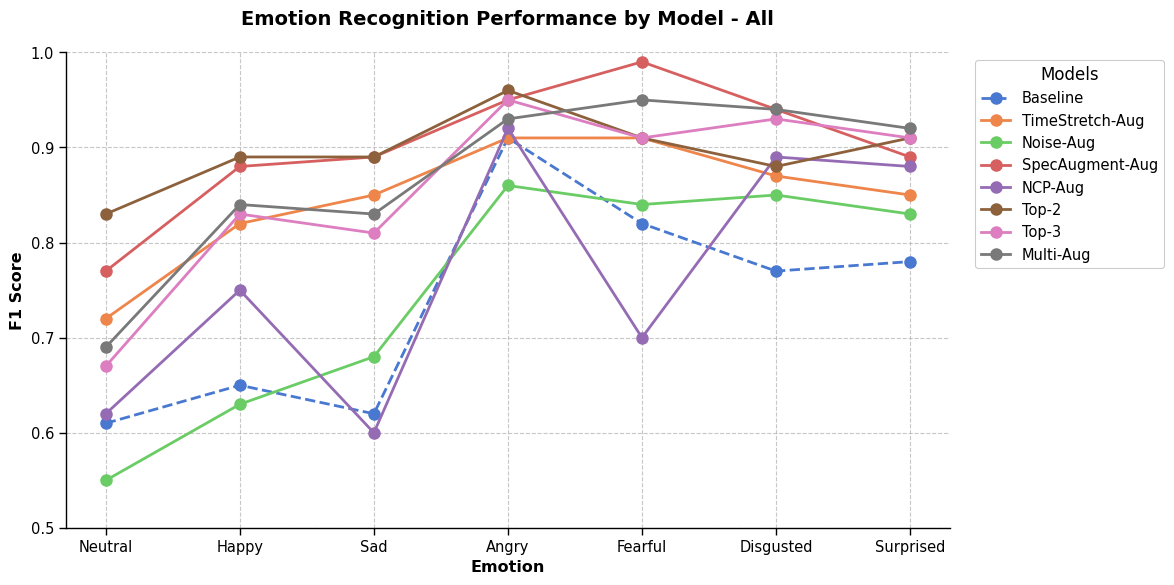

In [ ]:
# Set publication-ready style
plt.style.use('default')
sns.set_context("paper", font_scale=1.2)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Sample data (replace with your actual data)
emotions = ['Neutral', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

models = [
    'Baseline', 'TimeStretch-Aug', 'Noise-Aug',
    'SpecAugment-Aug', 'NCP-Aug', 'Top-2', 'Top-3', 'Multi-Aug'
]

# F1 scores for each model across emotions
f1_scores = {
    'Baseline':        [0.61, 0.65, 0.62, 0.91, 0.82, 0.77, 0.78],
    'TimeStretch-Aug': [0.72, 0.82, 0.85, 0.91, 0.91, 0.87, 0.85],
    'Noise-Aug':       [0.55, 0.63, 0.68, 0.86, 0.84, 0.85, 0.83],
    'SpecAugment-Aug': [0.77, 0.88, 0.89, 0.95, 0.99, 0.94, 0.89],
    'NCP-Aug':         [0.62, 0.75, 0.60, 0.92, 0.70, 0.89, 0.88],
    'Top-2':           [0.83, 0.89, 0.89, 0.96, 0.91, 0.88, 0.91],
    'Top-3':           [0.67, 0.83, 0.81, 0.95, 0.91, 0.93, 0.91],
    'Multi-Aug':       [0.69, 0.84, 0.83, 0.93, 0.95, 0.94, 0.92]
}

# Define color scheme similar to the bar chart (blues from dark to light)
colors = sns.color_palette("muted", 8)

linestyles = ['--', '-','-','-','-','-','-','-']
# Plot lines for each model
for i, model in enumerate(models):
    ax.plot(emotions, f1_scores[model],
            label=model,
            color=colors[i],
            linestyle=linestyles[i],
            marker='o',
            linewidth=2,
            markersize=8)

# Customize axes
ax.set_xlabel('Emotion', fontweight='bold')
ax.set_ylabel('F1 Score', fontweight='bold')
ax.set_ylim(0.5, 1)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(title='Models', title_fontsize=12,
          loc='upper right', bbox_to_anchor=(1.25, 1),
          ncol=1, frameon=True, framealpha=1)

# Add title
plt.title('Emotion Recognition Performance by Model - All',
          fontsize=14, fontweight='bold', pad=20)

# Save figure in high resolution
plt.tight_layout()
plt.savefig('emotion_performance_comparison_all.png', dpi=300, bbox_inches='tight')

plt.show()

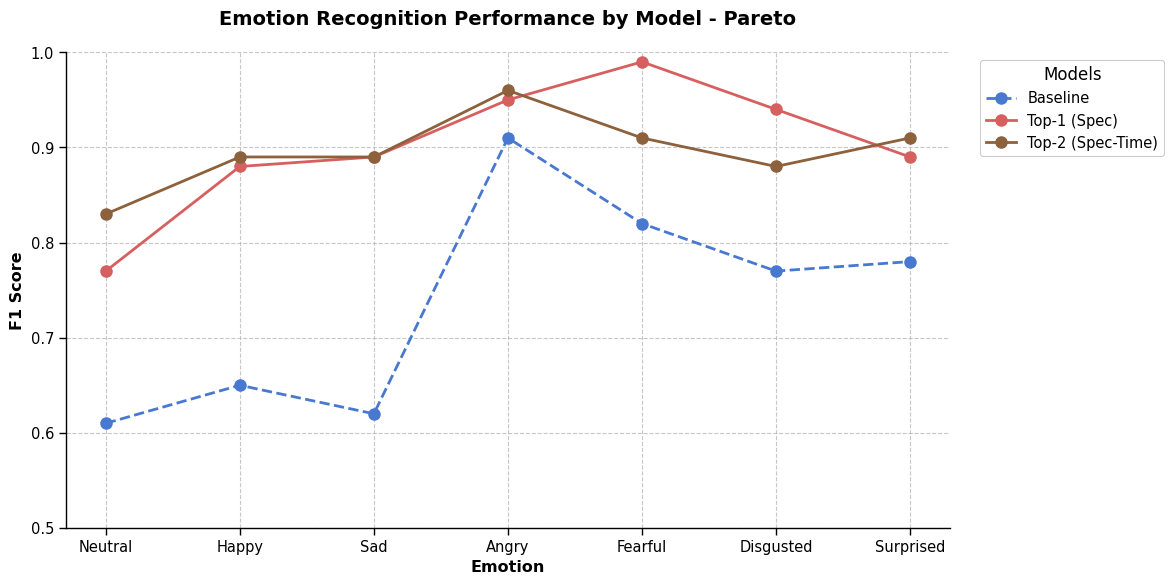

In [ ]:
# Set publication-ready style
plt.style.use('default')
sns.set_context("paper", font_scale=1.2)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Sample data (replace with your actual data)
emotions = ['Neutral', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

models = [
    'Baseline','Top-1 (Spec)', 'Top-2 (Spec-Time)'
]

# F1 scores for each model across emotions
f1_scores = {
    'Baseline': [0.61, 0.65, 0.62, 0.91, 0.82, 0.77, 0.78],
    'Top-1 (Spec)': [0.77, 0.88, 0.89, 0.95, 0.99, 0.94, 0.89],
    'Top-2 (Spec-Time)': [0.83, 0.89, 0.89, 0.96, 0.91, 0.88, 0.91],
}

# Define color scheme similar to the bar chart (blues from dark to light)
colors = ["#4878d0", "#d65f5f", "#8c613c"]

linestyles = ['--', '-','-','-','-','-','-','-']
# Plot lines for each model
for i, model in enumerate(models):
    ax.plot(emotions, f1_scores[model],
            label=model,
            color=colors[i],
            linestyle=linestyles[i],
            marker='o',
            linewidth=2,
            markersize=8)

# Customize axes
ax.set_xlabel('Emotion', fontweight='bold')
ax.set_ylabel('F1 Score', fontweight='bold')
ax.set_ylim(0.5, 1)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(title='Models', title_fontsize=12,
          loc='upper right', bbox_to_anchor=(1.25, 1),
          ncol=1, frameon=True, framealpha=1)

# Add title
plt.title('Emotion Recognition Performance by Model - Pareto',
          fontsize=14, fontweight='bold', pad=20)

# Save figure in high resolution
plt.tight_layout()
plt.savefig('emotion_performance_comparison_pareto.png', dpi=300, bbox_inches='tight')

plt.show()